In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print (" SystemError('GPU device not found It is ok, you only need for training'")
print('Found GPU at: {}'.format(device_name))

 SystemError('GPU device not found It is ok, you only need for training'
Found GPU at: 


In [5]:
#install import stuff
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!pip install -U keras

gpg: keybox '/tmp/tmp5ffs3pk8/pubring.gpg' created
gpg: /tmp/tmp5ffs3pk8/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
Requirement already up-to-date: keras in /usr/local/lib/python2.7/dist-packages (2.2.2)


In [0]:
#mount google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:
%cd
%cd drive
%mkdir shapley_mnist
%cd shapley_mnist
#download model parameters
!if [ ! -f "mnist.h5" ]; then wget https://www.dropbox.com/s/dvgrcza2roul0ug/mnist.h5?dl=0 -O mnist.h5 ; fi
!if [ ! -f "dictt_BetterSampling_mnist.npy.gz" ]; then wget https://www.dropbox.com/s/l1mrzntyjp5mmbx/dictt_BetterSampling_mnist.npy.gz?dl=0 -O dictt_BetterSampling_mnist.npy.gz ; fi
%ls -lh */
%ls -lh


/content
/content/drive
mkdir: cannot create directory ‘shapley_mnist’: File exists
/content/drive/shapley_mnist
drive/:
total 0

MNIST_data/:
total 12M
-rw-r--r-- 1 root root 1.6M Jul 23 07:37 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Jul 23 07:37 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Jul 23 07:37 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Jul 23 07:37 train-labels-idx1-ubyte.gz
total 29M
-rw-r--r-- 1 root root  21M Jul 25 02:07 dictt_BetterSampling_mnist.npy.gz
drwxr-xr-x 2 root root 4.0K Jul 23 07:40 drive/
drwxr-xr-x 2 root root 4.0K Jul 23 07:36 MNIST_data/
-rw-r--r-- 1 root root 3.5M Jul 23 07:35 mnist.h5
-rw-r--r-- 1 root root 3.5M Jul 24 07:41 untrained.mnist
-rw-r--r-- 1 root root 903K Jul 25 02:13 Visual.png


# **1. Keras training/loading of weights starts here**

In [8]:
# -*- coding: utf-8 -*-
#import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gzip
import keras

from keras.layers import Input



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras import backend as K

print ('tf.__version__',tf.__version__)
print ('keras.__version__',keras.__version__)


#https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

from tensorflow.examples.tutorials.mnist import input_data
k.set_learning_phase(0)
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
model = Sequential()
Input 
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'linear'))
model.add(keras.layers.Activation('softmax'))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


model.summary()
batch_size = 64

X_train = mnist.train.images
X_train = np.reshape(X_train,(X_train.shape[0],28,28,1))
X_val = mnist.test.images
X_val = np.reshape(X_val,(X_val.shape[0],28,28,1))[::1]
y_train = mnist.train.labels
y_val = mnist.test.labels[::1]

import os
if 'mnist.h5' not in os.listdir('.'):
    print ('weights not found, training model')
  # With data augmentation to prevent overfitting (accuracy 0.99286)
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    batch_size = 64
    epochs = 20
    X_train = mnist.train.images
    X_train = np.reshape(X_train,(X_train.shape[0],28,28,1))
    X_val = mnist.test.images
    X_val = np.reshape(X_val,(X_val.shape[0],28,28,1))
    Y_train = mnist.train.labels
    Y_val = mnist.test.labels
    datagen.fit(X_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    model.save_weights('mnist.h5')
  
  
else:
    print ('weights are found, loading weights')
    model.load_weights('mnist.h5') 



Using TensorFlow backend.


('tf.__version__', '1.10.0-rc1')
('keras.__version__', '2.2.2')
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_______________________________________

# **2. Evaluating performanace of trained model**

In [9]:
print ('predicting train set')
pred = model.predict(X_train[::2],batch_size =512)
pred2 = np.argmax(pred,1)
print  ('Estimated Accuracy of train set',np.mean(pred2==np.argmax(y_train[::2],1)))
print  ('Esimated Inaccurately predicted',2*np.sum(pred2!=np.argmax(y_train[::2],1)))
print ('Total train set size',2*len(pred))
print ('predicting test set')
pred = model.predict(X_val,batch_size =512)
pred2 = np.argmax(pred,1)
print  ('Accuracy of test set',np.mean(pred2==np.argmax(y_val,1)))
print  ('Inaccurately predicted',np.sum(pred2!=np.argmax(y_val,1)))
print ('Total test set size',len(pred))
confusion_matrix(np.argmax(y_val,1),np.argmax(pred,1))

predicting train set
('Estimated Accuracy of train set', 0.9924727272727273)
('Esimated Inaccurately predicted', 414)
('Total train set size', 55000)
predicting test set
('Accuracy of test set', 0.9946)
('Inaccurately predicted', 54)
('Total test set size', 10000)


array([[ 977,    0,    0,    0,    1,    0,    1,    0,    0,    1],
       [   0, 1131,    1,    1,    0,    0,    1,    1,    0,    0],
       [   1,    0, 1027,    1,    0,    0,    0,    3,    0,    0],
       [   0,    0,    0, 1006,    0,    2,    0,    1,    1,    0],
       [   0,    0,    0,    0,  981,    0,    0,    0,    0,    1],
       [   0,    0,    0,    2,    0,  888,    1,    1,    0,    0],
       [   2,    1,    0,    0,    0,    1,  952,    0,    2,    0],
       [   0,    3,    3,    0,    1,    0,    0, 1020,    0,    1],
       [   0,    0,    2,    1,    3,    0,    0,    0,  967,    1],
       [   0,    0,    0,    0,   10,    0,    0,    2,    0,  997]])

# **3. Calculating shapley values**

In [10]:
import gzip
print ('loading pre computed shapley values')
dictt = np.load(gzip.GzipFile('dictt_BetterSampling_mnist.npy.gz')).item()
for i in dictt.keys():
      dictt[i] += [pred[i],]
print len(dictt)
# uncomment below to calculate shapley values

loading pre computed shapley values
9650


In [0]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':  ((0, 0, 0),   # <- at 0.0, the red component is 0
                   (0.33, 1, 1.0),   # <- at 0.5, the red component is 1
                   (1, 1.0, 1.0)),  # <- at 1.0, the red component is 0

         'green': ((0, 0.0, 0.0),   # <- etc.
                   (0.33, 1.0, 1.0),
                   (1, 0.0, 0.0)),

         'blue':  ((0, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (1, 0, 0))
         }
bwr = LinearSegmentedColormap('bwr', cdict1)

## (calculating shapley values (hidden))

In [0]:
#@title
#title
### WARNING THIS WILL PRINT MANY MANY THINGS ###
if False: #uncomment to compute shapley values
      print ('Computing shapley values\n### WARNING THIS WILL PRINT MANY MANY THINGS ###')
      X_val_ids_to_compute = range(len(X_val))[::]
      pred2 = np.argmax(pred,1)
      import gc
      filename= 'dictt_BetterSampling_mnist.npy'
      def slic(img, n_segments=49, compactness=10, sigma=0.5):
          new_img = np.copy(img[:,:,0])
          counter =0
          for i in range(0,28,4)[:]:
              for j in range(0,28,4)[:]:
                  a,b = 4,4
                  new_img[i:i+a,j:j+b] = counter
                  counter += 1
          return new_img.astype(np.int32)
      import itertools
      import scipy
      dictt ={}
      import os
      if filename+'.gz' in os.listdir('.'):
          dictt= np.load(gzip.GzipFile(filename+'.gz')).item()
      for i  in X_val_ids_to_compute:
          if i in dictt.keys() and i != X_val_ids_to_compute[0]:
             print i,'in dictt.keys()'
             continue
          temp = [[],]*10
          feature_names={'0':'late blight','1':'leaf mold','2':'leaf spot','3':'healthy'}
          img = X_val[i]
          import copy
          img_orig = copy.deepcopy(img)
          segments_slic = (slic(img, n_segments=34, compactness=10, sigma=0.5))
          preds_1  =model.predict(X_val[i:i+1])
          max_val = np.max(segments_slic)+1 #segment is from 0 to n-1
          vec = np.array(range(max_val))
          if i == X_val_ids_to_compute[0]:
            num =10000
            num_comb = 0
            sample_index = []
            counter = 0
            while num_comb < num:
                num_comb += 1*scipy.misc.comb(max_val,counter)
                counter += 1
            for num_of_chosen in range(1,counter):
                if num_of_chosen < counter-1:
                    sample_index += list(itertools.combinations(range(max_val), max_val-num_of_chosen))
                else:
                     sample_index += list(itertools.combinations(range(max_val), max_val-num_of_chosen))[::3]

            X_simple = np.array(map(lambda x : 1*np.isin(segments_slic,x),sample_index)).astype(np.float32)
          random_array = []
          for l2 in sample_index:
              temp2 = np.zeros(max_val)
              for j2 in l2:
                  temp2[j2] = 1
              random_array += [temp2,]
          random_array  = np.stack(random_array,0).astype(np.float32)
          print ('X_simple.shape:', X_simple.shape)
          gc.collect()
          import scipy
          M=max_val

          def shapley_kernel(x): #weights for each point
            return (M-1)/(scipy.misc.comb(M,len(x))*len(x)*(M-len(x)))
          W_mat = np.diag(map(shapley_kernel,sample_index)).astype(np.float32)
          X= np.stack([X_simple,]*1,-1)*np.stack([img,]*len(X_simple))+.0*np.mean(img)*(np.stack([X_simple,]*1,-1)==0).astype(np.float32)
          gc.collect()
          Y_pred = model.predict(X,batch_size = 512/4) 
          print ('Y_pred.shape:',Y_pred.shape)
          print ('Y_pred[0]:',Y_pred[0])
          Y_pred = np.log((0.000001+Y_pred)/(1.000001-Y_pred)) 
          print ("len(Y_pred):",len(Y_pred))
          print ("preds_1:",preds_1)
          #φ = (X T W X) −1 X T W y
          for ii in range(len(Y_pred[0])):
              XtWX_inv = np.linalg.inv(np.matmul(np.matmul(random_array.T,W_mat),random_array))
              temp[ii] = np.matmul(np.matmul(np.matmul(XtWX_inv,random_array.T),W_mat),Y_pred[:,ii])
          dictt[i] = [img,temp, segments_slic,y_val[i] ] 
          if len(dictt) %10 == 0:
            np.save(filename,dictt)
            print ("len(dictt):",len(dictt))
      np.save(filename,dictt)
    
      for i in dictt.keys():
          dictt[i] += [pred[i],]
      print len(dictt)



# **4. Global analysis of shapley values**

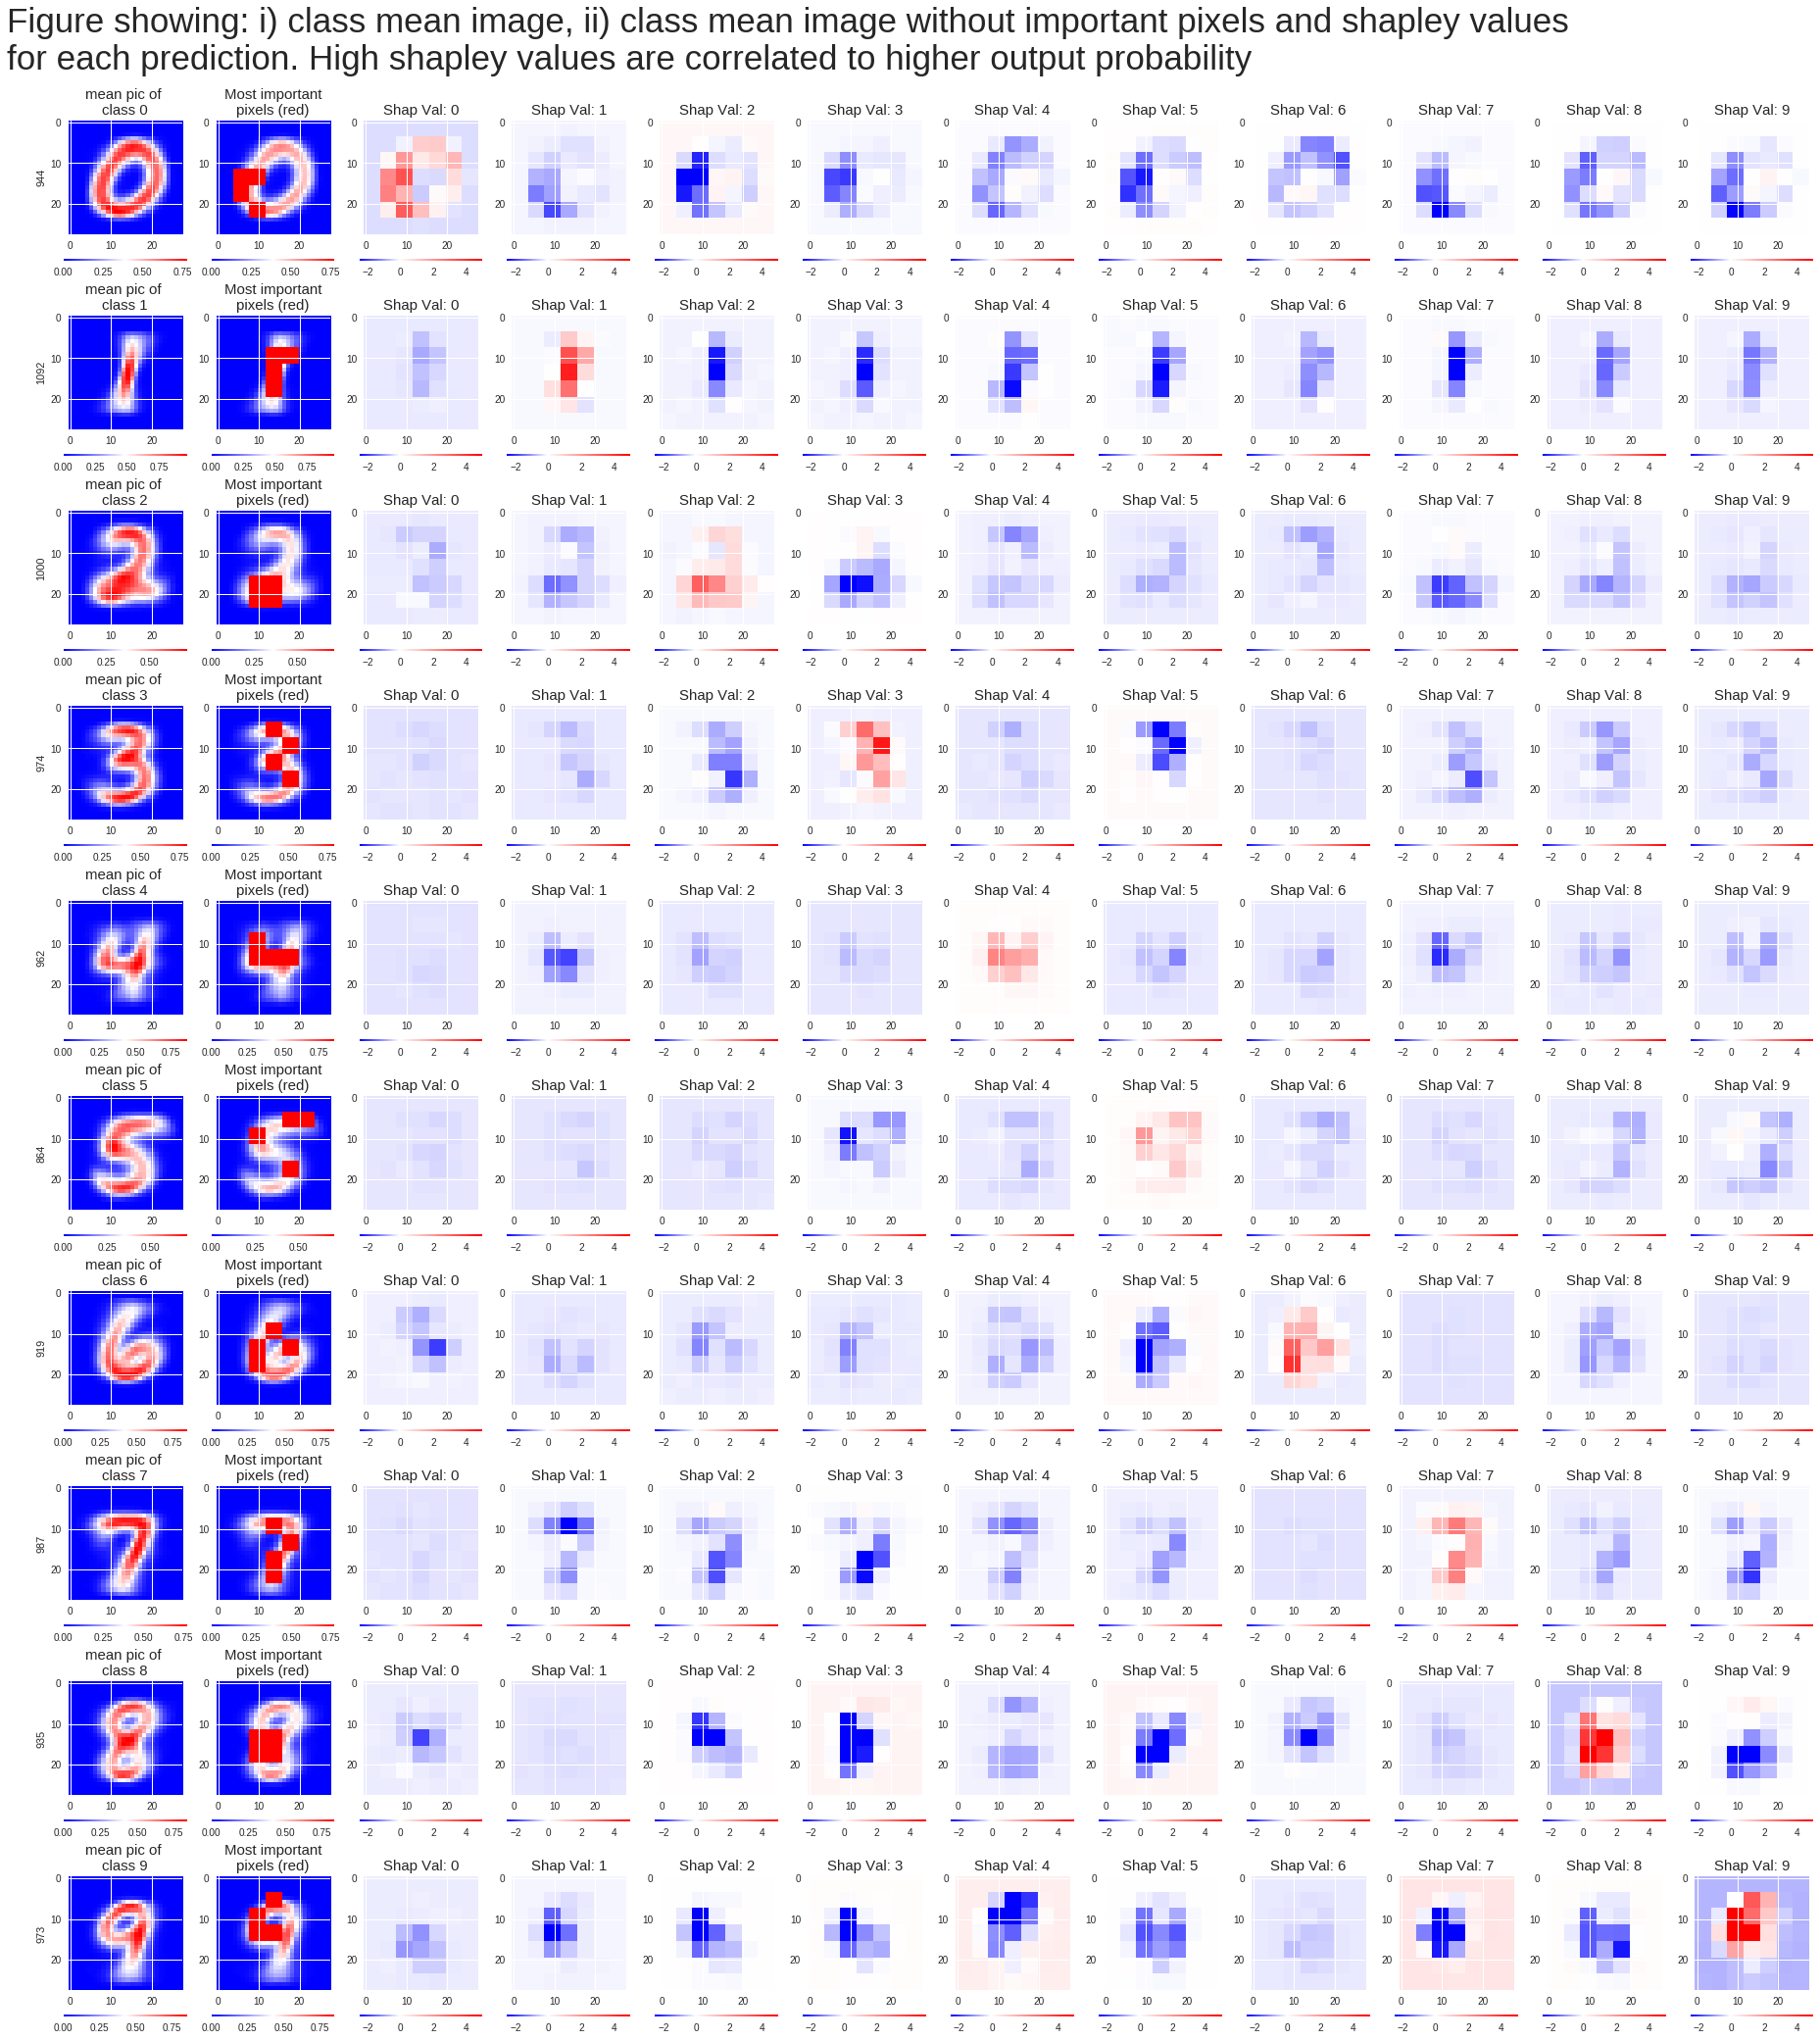

In [13]:
fontsize = 15
import copy
dictt_avg_plts = {}
f,ax = plt.subplots(10,12,figsize=(16*2,2*18))
plt.figtext(0.10, 0.90, 'Figure showing: i) class mean image, ii) class mean image without important pixels and shapley values\nfor each prediction. High shapley values are correlated to higher output probability', 
            horizontalalignment='left',fontsize=35) 
for digit in range(10):
    all_pic = np.stack([dictt[x][0][:,:,0] for x in dictt.keys() 
                  if (np.argmax(dictt[x][-1]) == digit and 
                    np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    avg_pic = np.mean(all_pic,0)
    cax1 = ax[digit,0].imshow(avg_pic,cmap = plt.cm.bwr)
    dictt_avg_plts[(digit,0)] = copy.deepcopy(avg_pic)
    cb = plt.colorbar(cax1,  ax=ax[digit,0],ticks=[0,.25,.5,.75], orientation="horizontal", aspect=70) 
    ax[digit,0].set_title('mean pic of \nclass %s'%digit,fontsize=fontsize)
    ax[digit,0].set_ylabel(len(all_pic))
    #a = np.stack([(np.stack(dictt[x][1],0)- np.stack([np.mean(dictt[x][1],1),],-1))/np.stack([np.std(dictt[x][1],1),],-1)
    #              for x in dictt.keys() 
    #              if (np.argmax(dictt[x][-1]) == digit and 
    #                  np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    a = np.stack([np.stack(dictt[x][1],0)
                  for x in dictt.keys() 
                  if (np.argmax(dictt[x][-1]) == digit and 
                      np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    phi = np.mean(a,(0))
    #phi = (phi - np.stack([np.mean(phi,-1),],-1))/np.stack([np.std(phi,-1),],-1)
    b = np.stack([np.stack(dictt[x][-1],0) for x in dictt.keys() 
                  if (np.argmax(dictt[x][-1]) == digit and 
                    np.sum(np.isnan(np.stack(dictt[x][1],0)))==0)],0)
    median_preds_for_digit = map(lambda x: np.round(x,1), np.log10(np.median(b,0)))
    for preds in range(0,10):
        shapley_image = np.copy(dictt[0][2].astype(np.float32))
        for x in range(28):
            for y in range(28):
                shapley_image[x,y] = phi[preds][int(shapley_image[x,y])]
        min_val = np.min(phi[preds])
        max_val = np.max(phi[preds])
        cax = ax[digit,preds+2].imshow(shapley_image,vmin=-2.5, 
                                       vmax=5,cmap = bwr)
        dictt_avg_plts[(digit,preds+2)] = copy.deepcopy(shapley_image)
        ax[digit,preds+2].set_title('Shap Val: %s%s' %(preds,''),fontsize=fontsize)
        max_minus_min_Phi = max_val-min_val
        cb = plt.colorbar(cax,  ax=ax[digit,preds+2],
                          ticks=[-2,0,2,4], 
                          orientation="horizontal", aspect=70) 
        if preds == digit:
            largest_shap_val = np.percentile(np.concatenate(shapley_image),90)
            avg_pic[shapley_image > largest_shap_val] = 1 
            cax = ax[digit,1].imshow(avg_pic,cmap = plt.cm.bwr)
            ax[digit,1].set_title('Most important\npixels (red)',fontsize=fontsize)
            cb = plt.colorbar(cax1,  ax=ax[digit,1],ticks=[0,.25,.5,.75], orientation="horizontal", aspect=70) 
plt.savefig('Visual.png',dpi=200, bbox_inches='tight')
plt.show()

    


# **6. Shapley value analysis of wrong predictions**

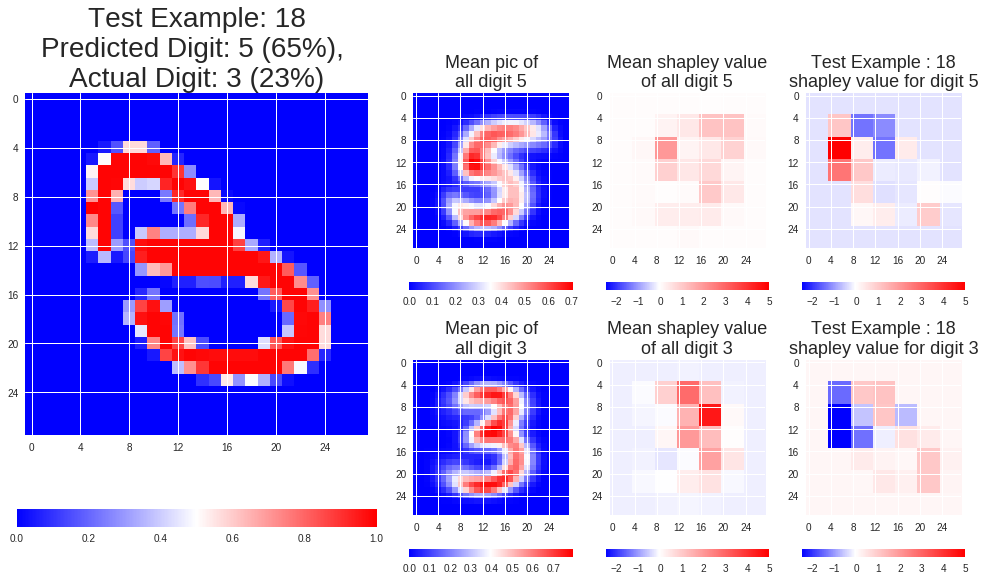

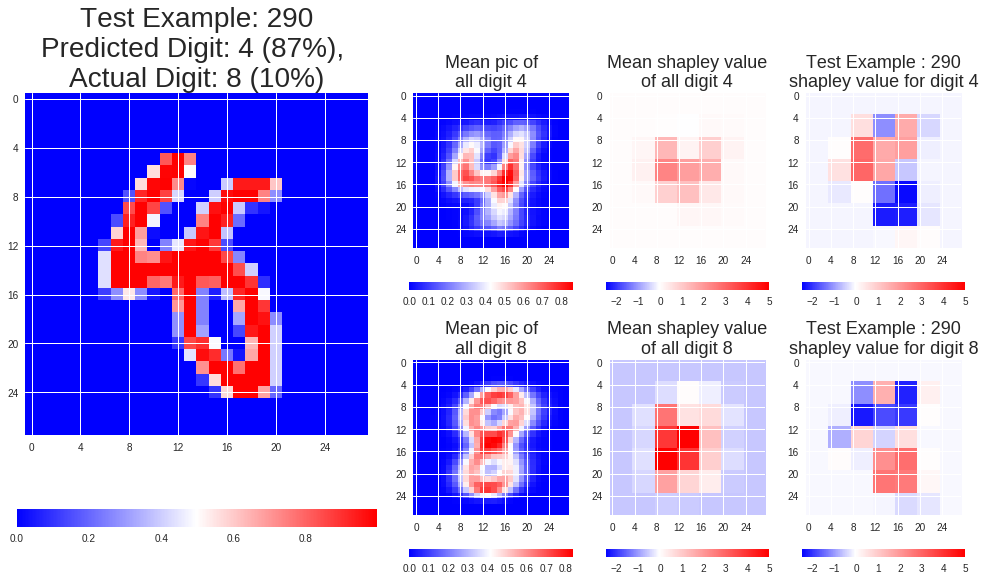

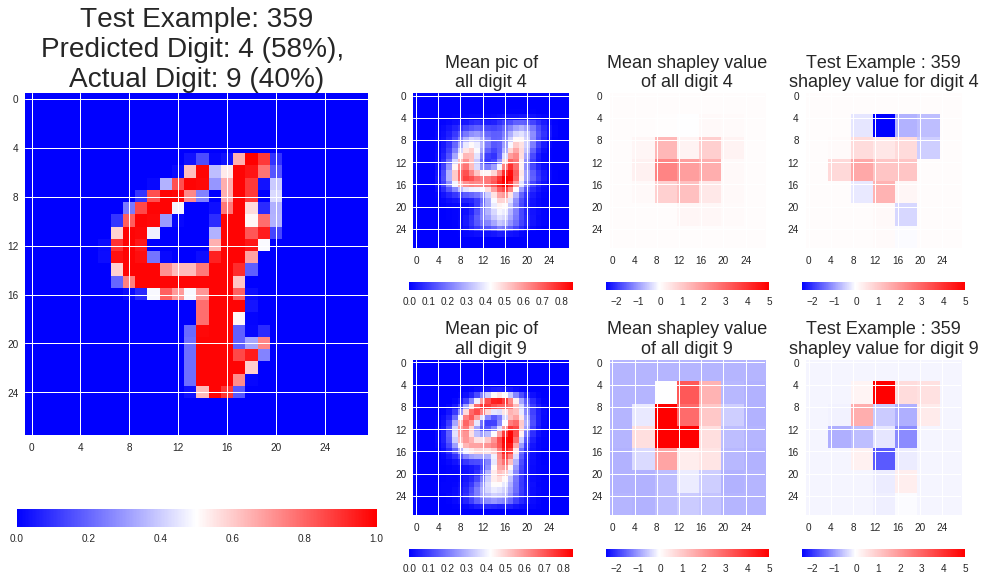

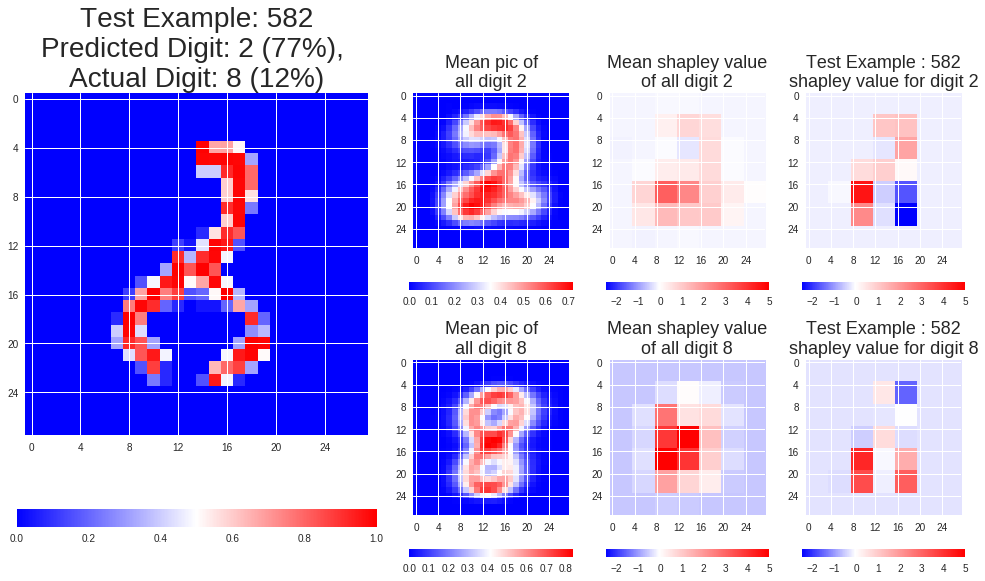

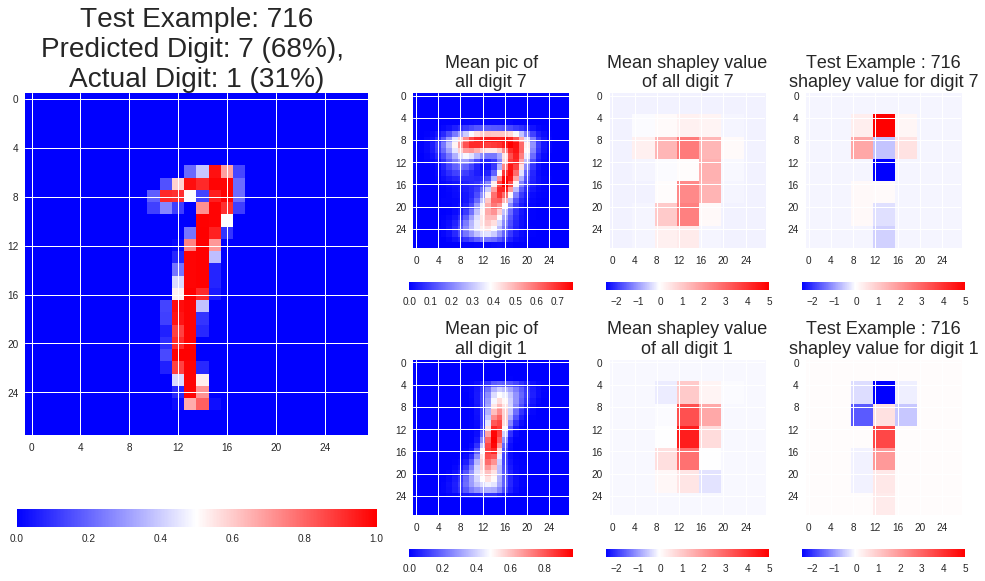

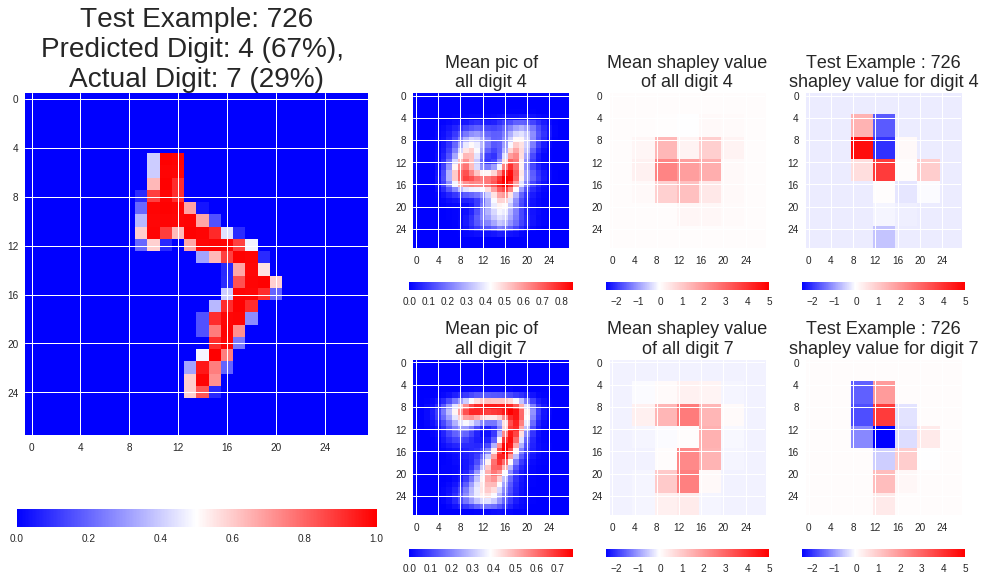

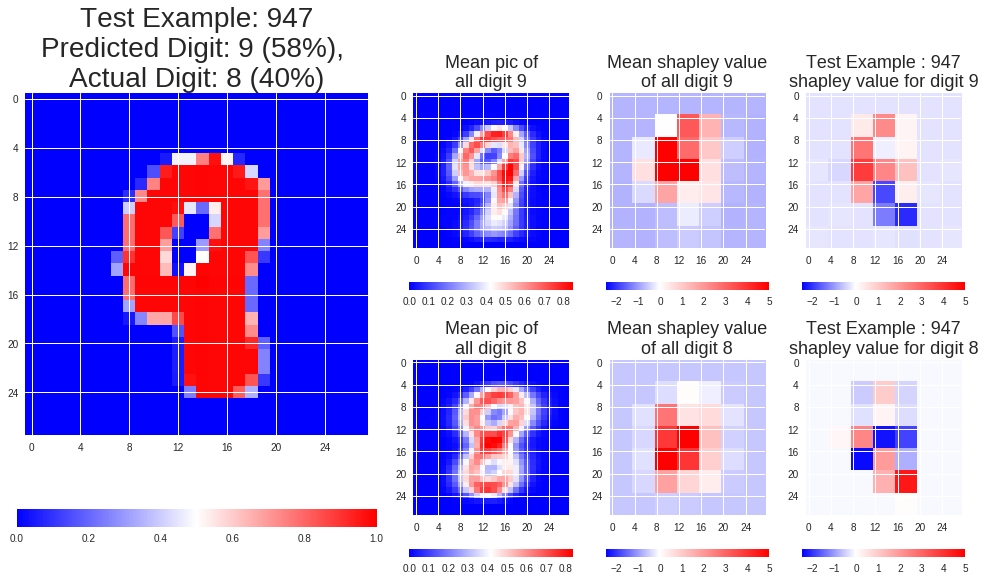

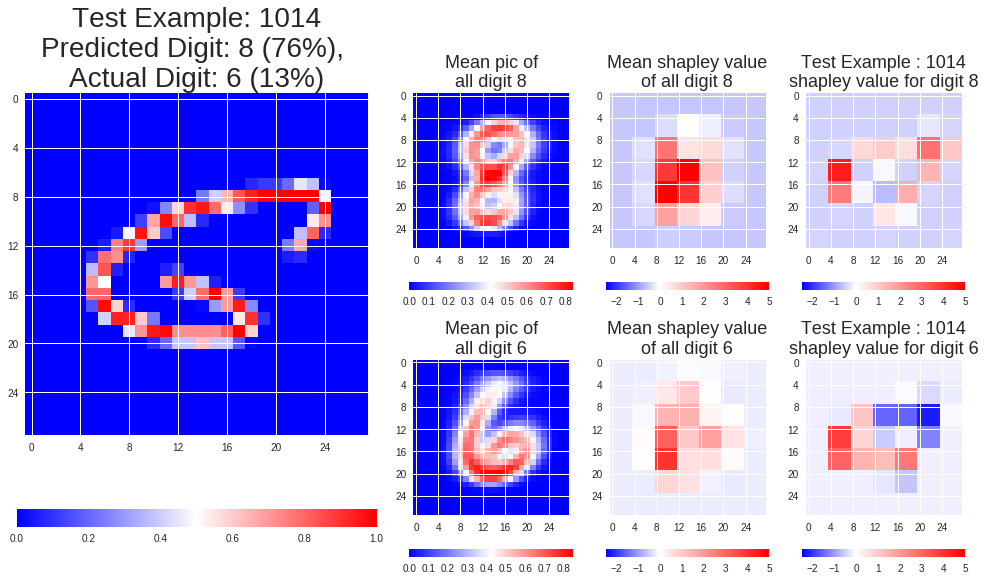

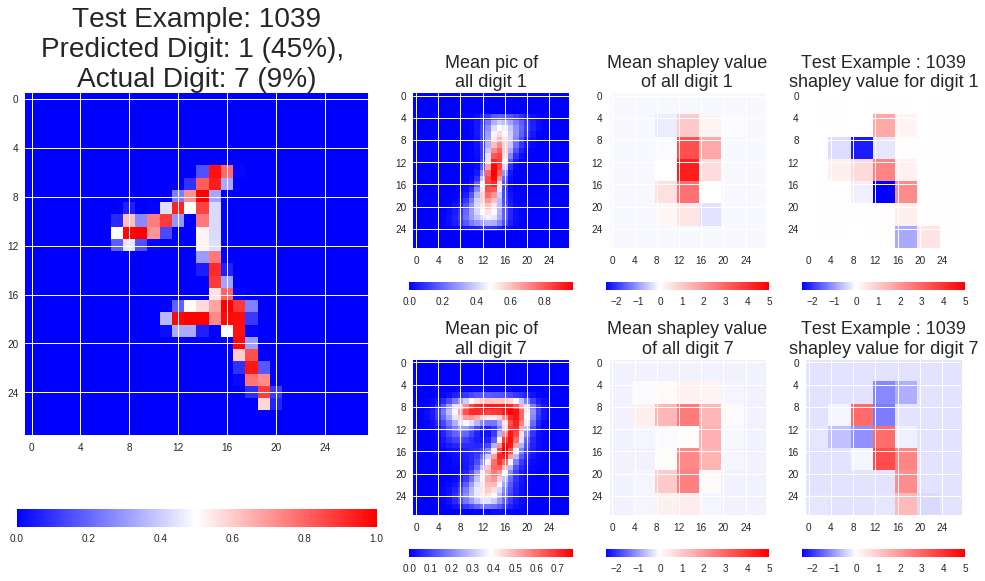

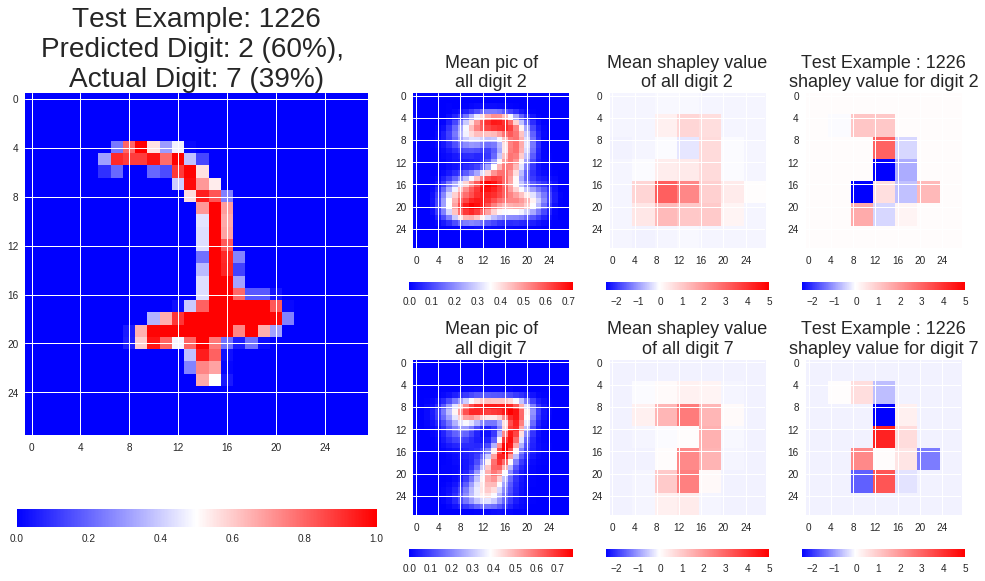

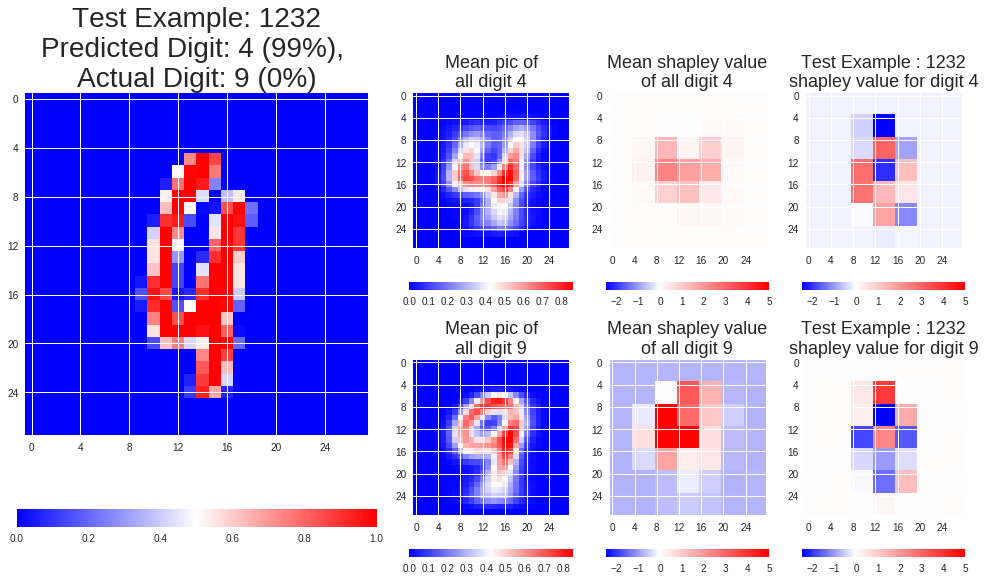

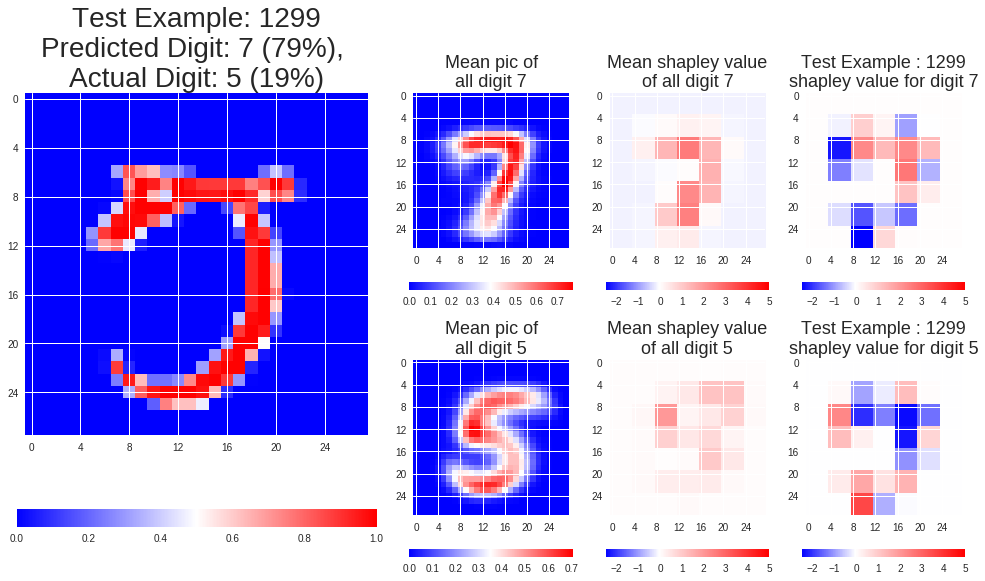

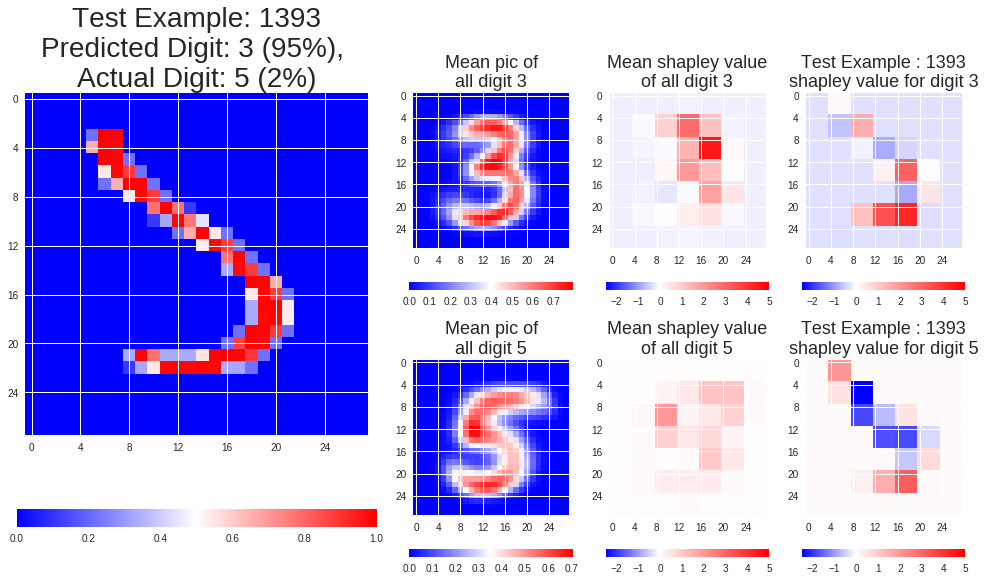

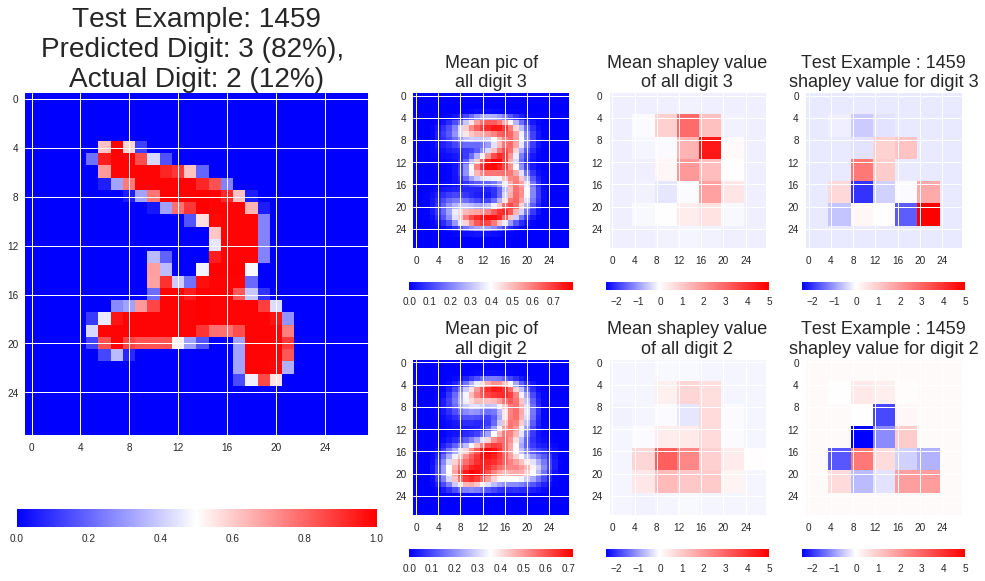

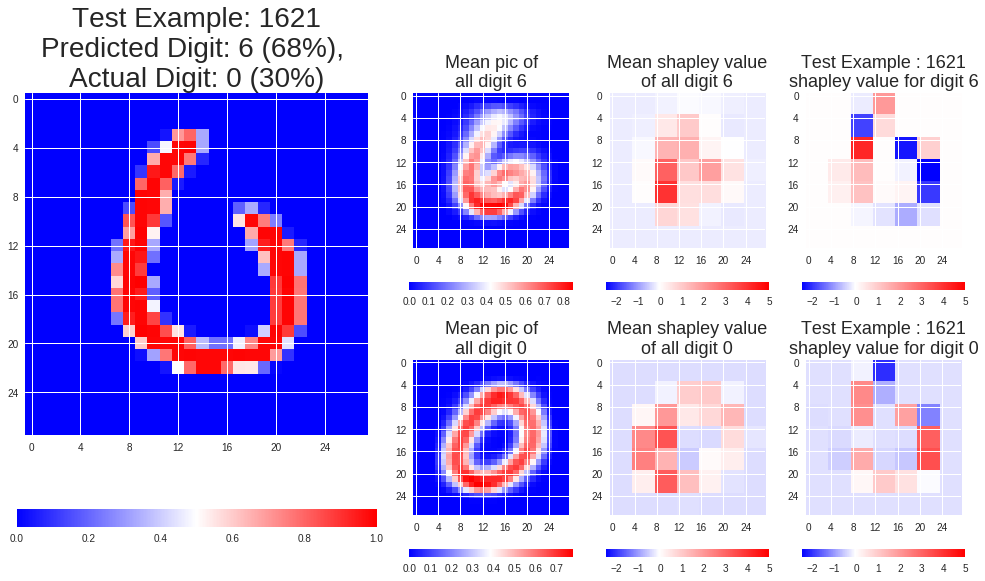

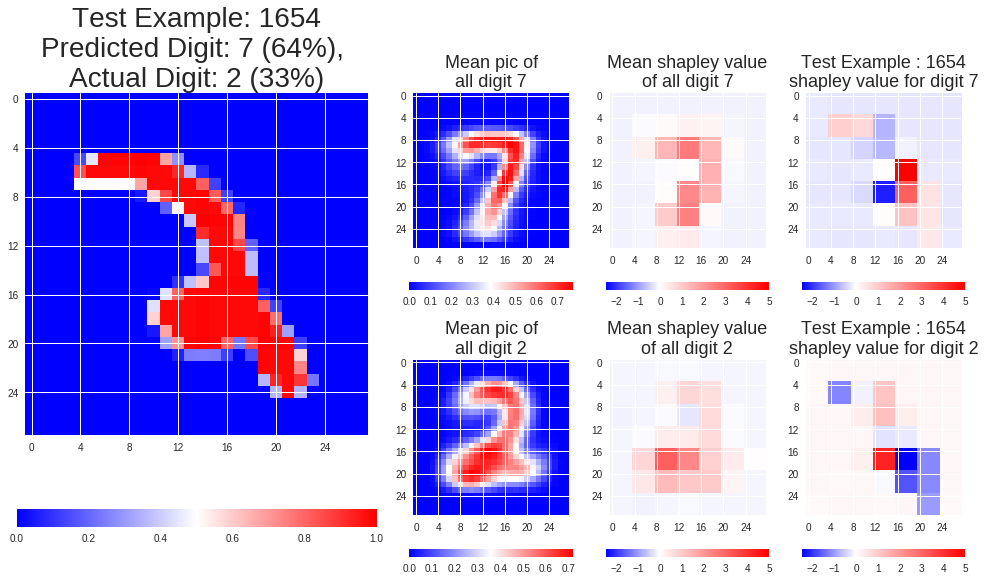

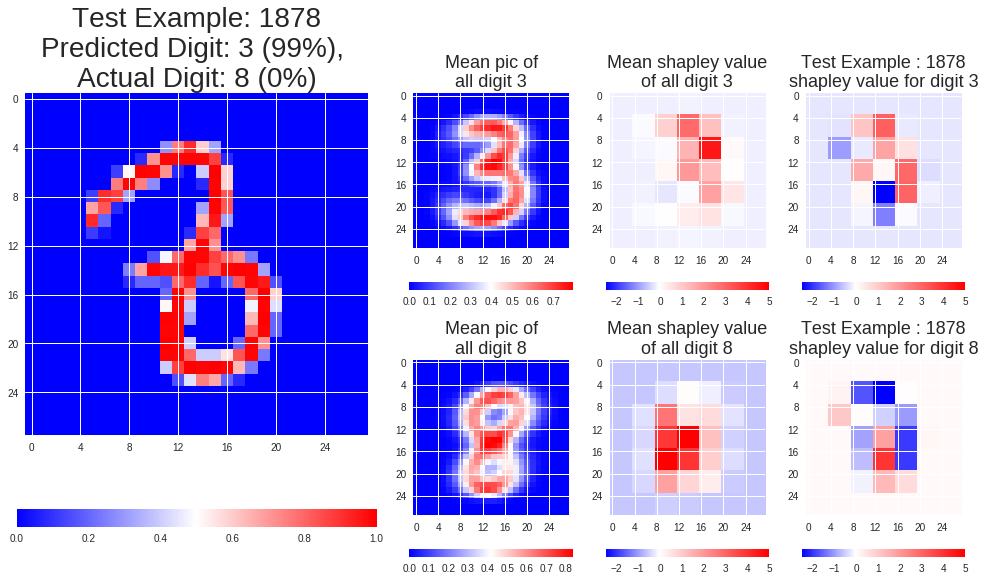

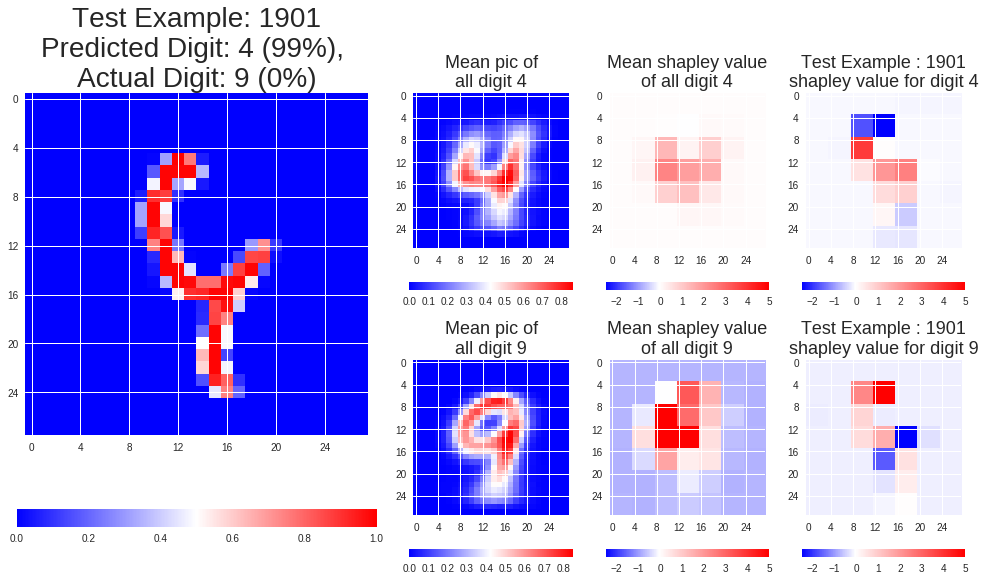

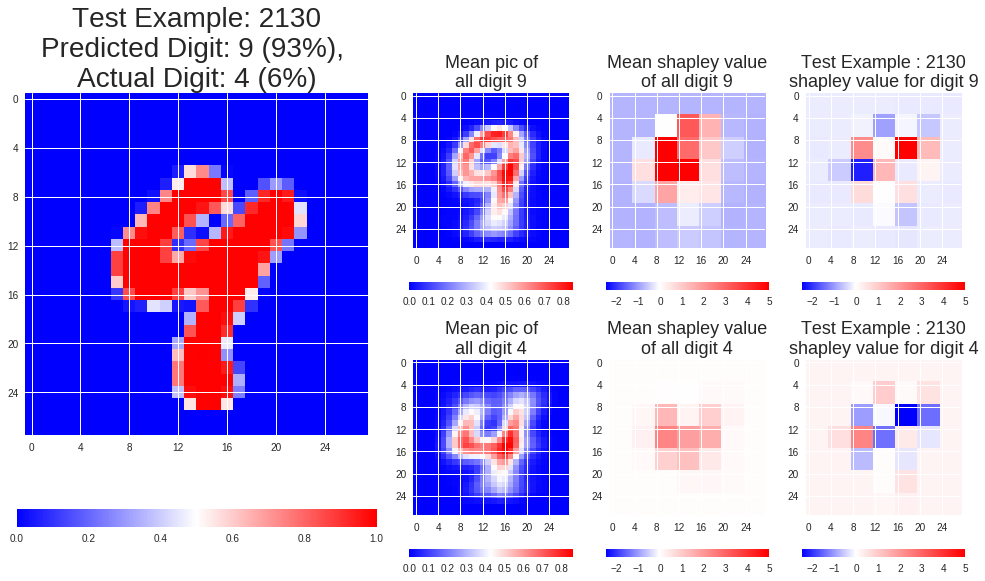

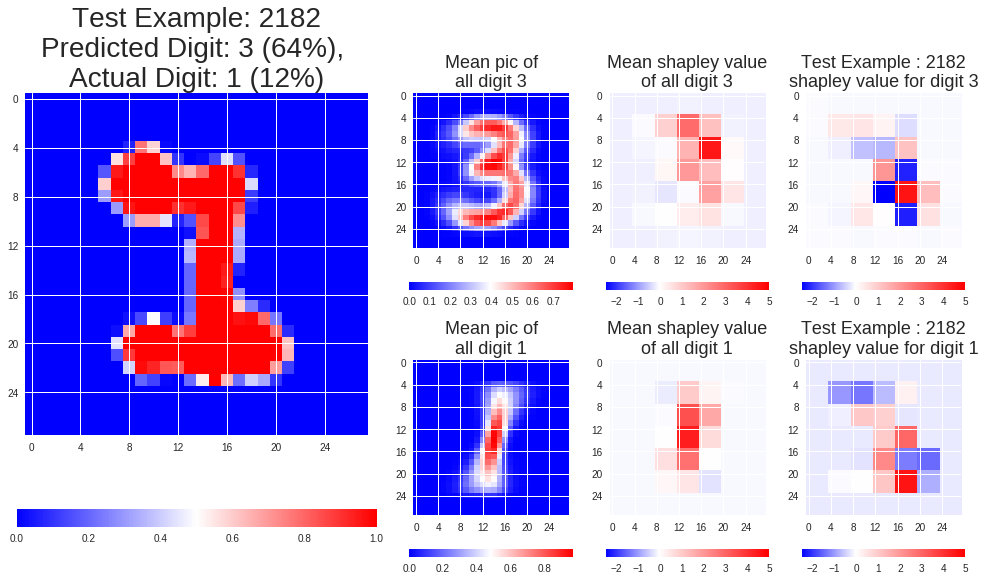

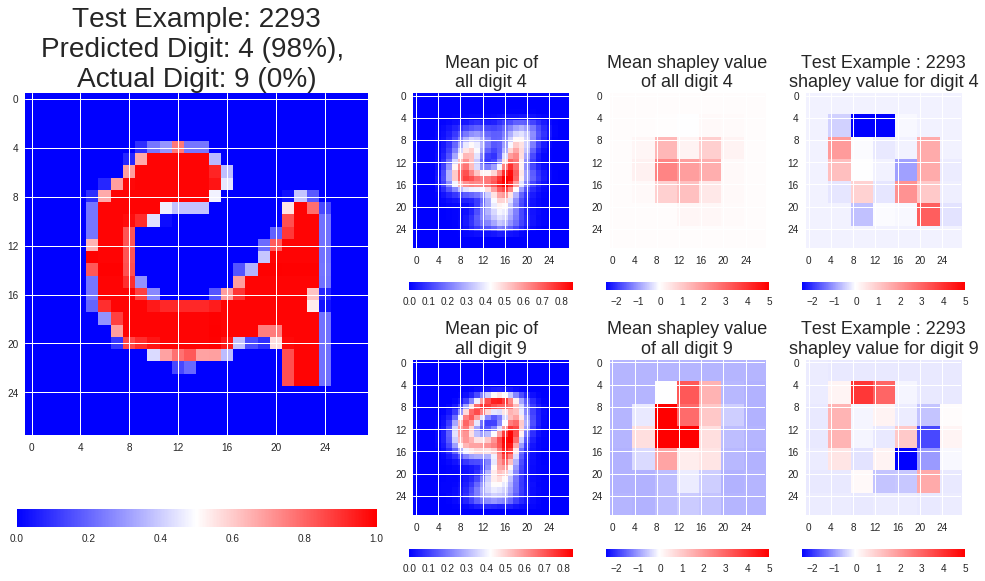

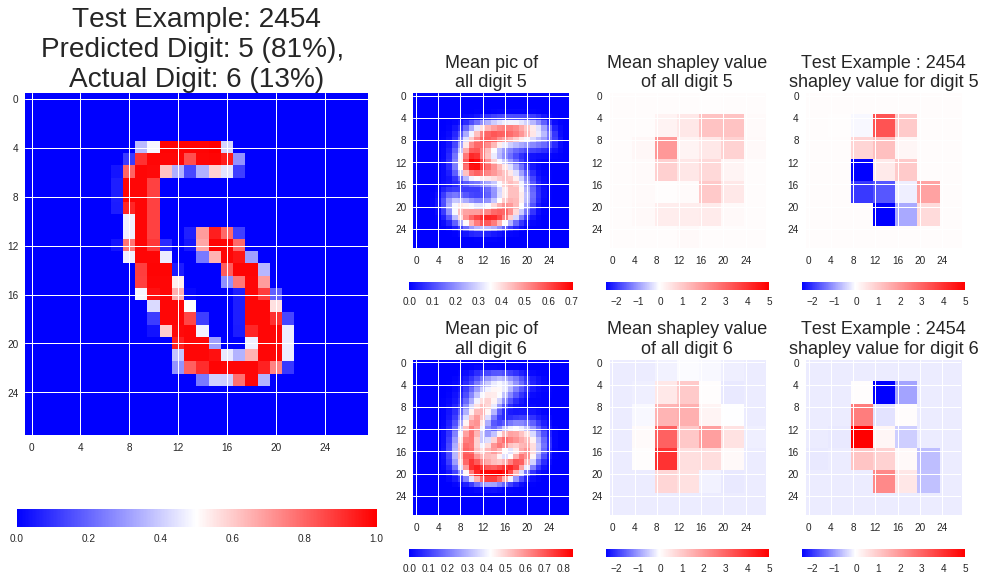

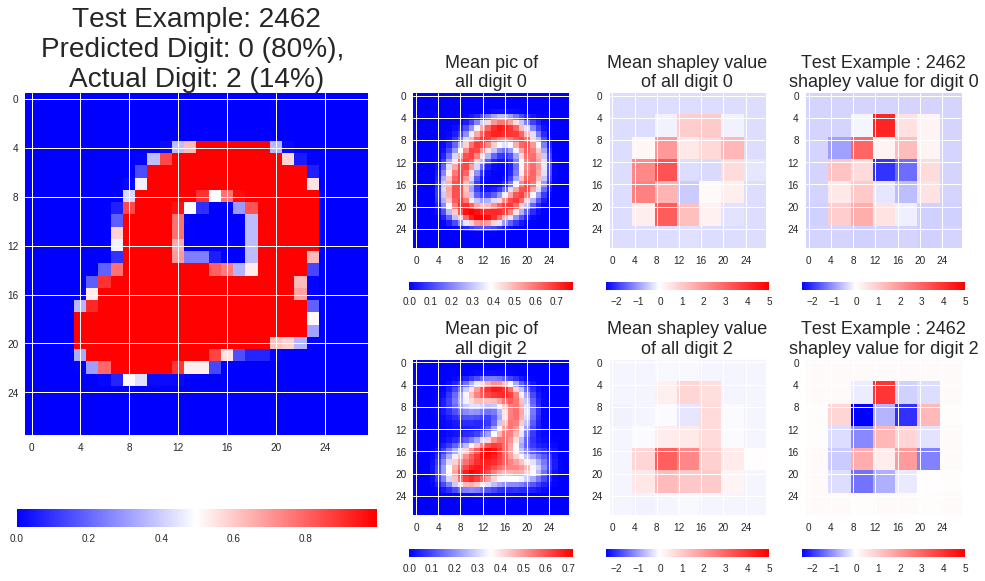

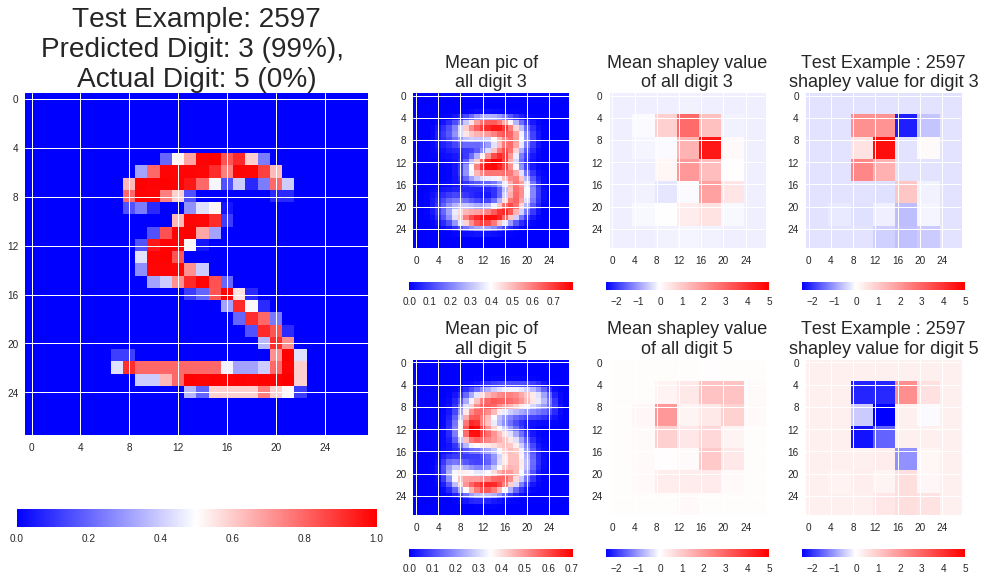

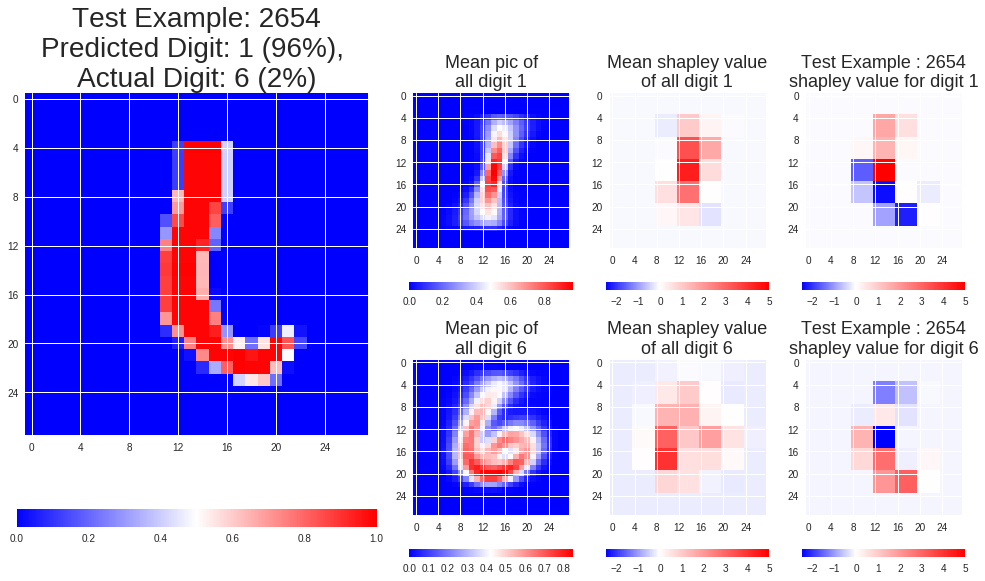

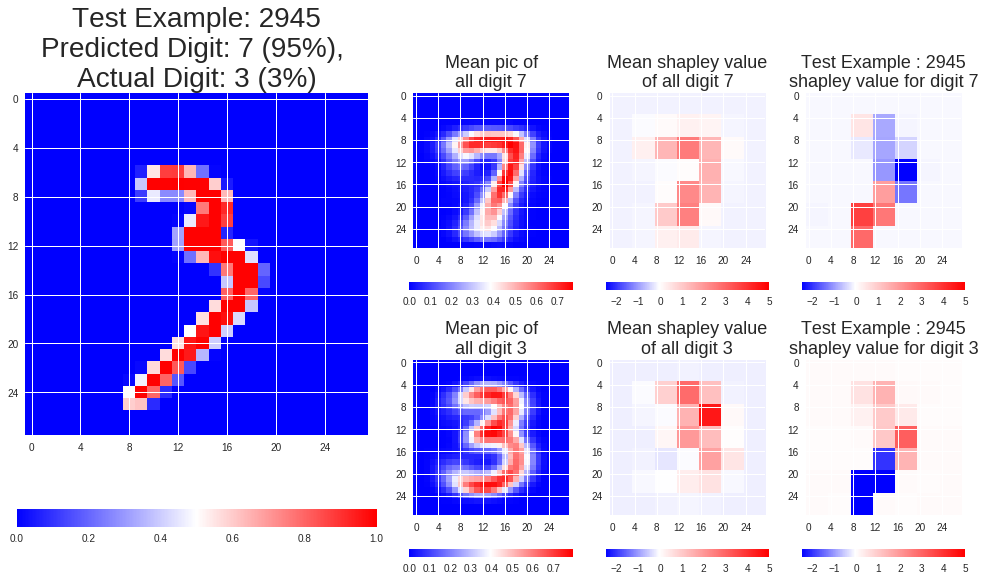

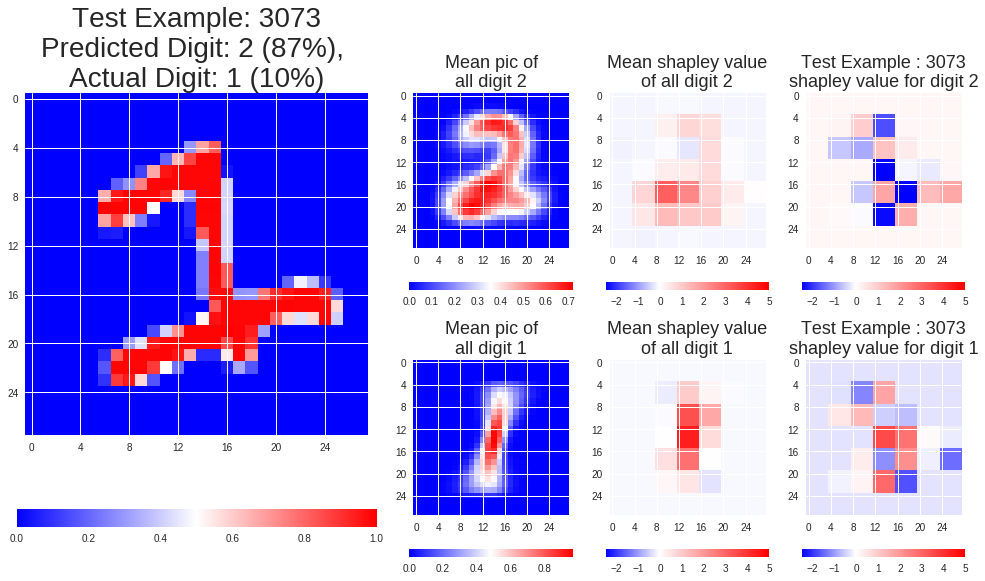

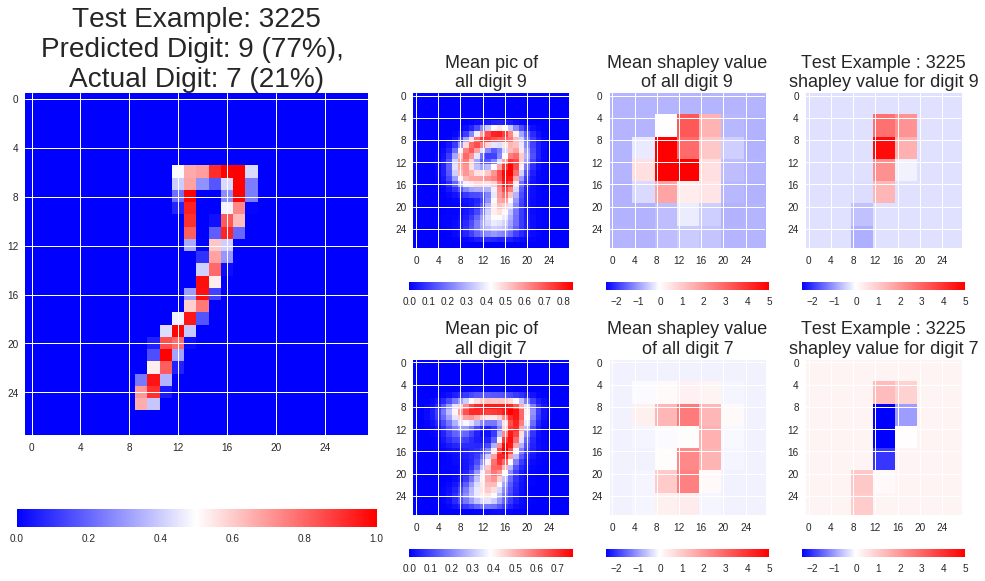

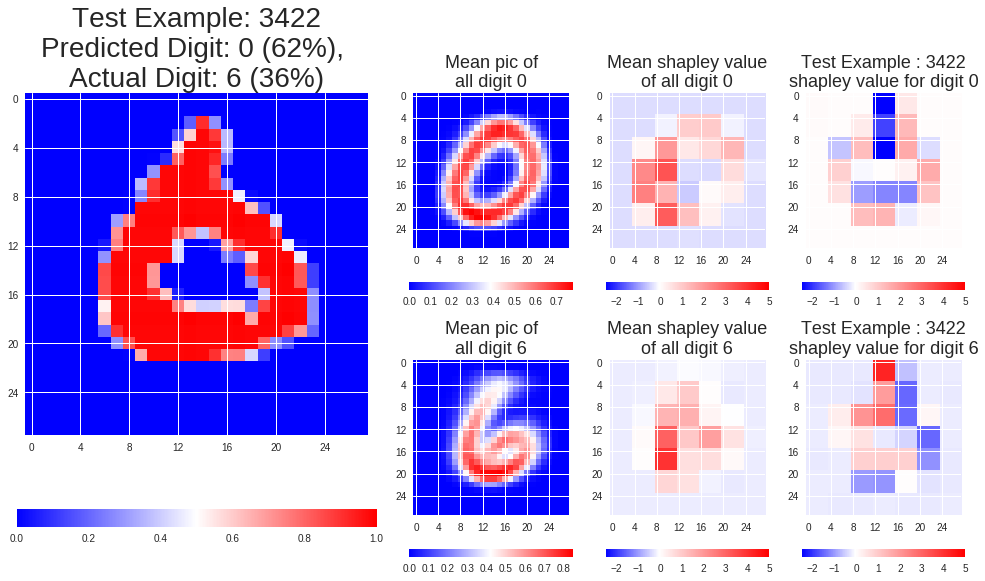

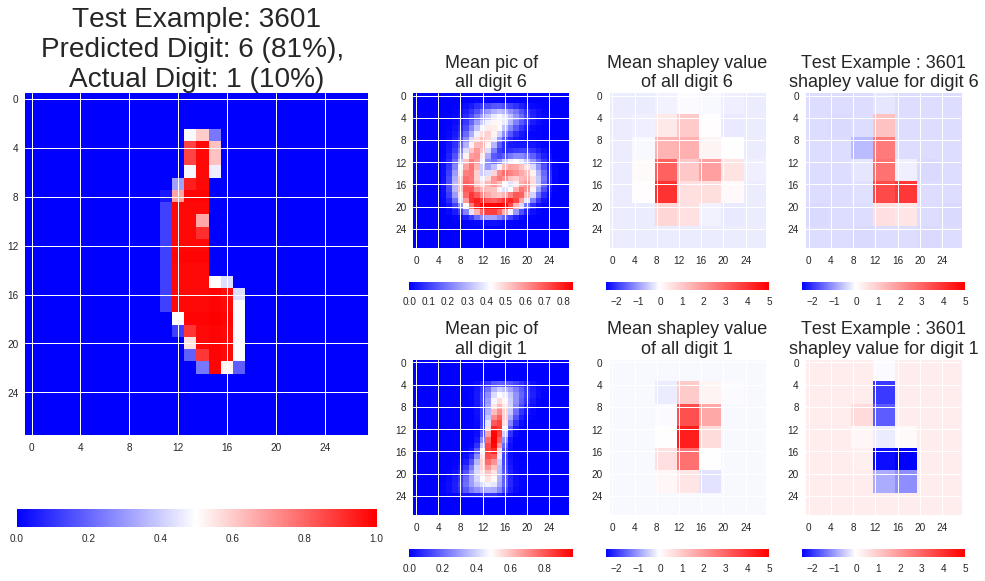

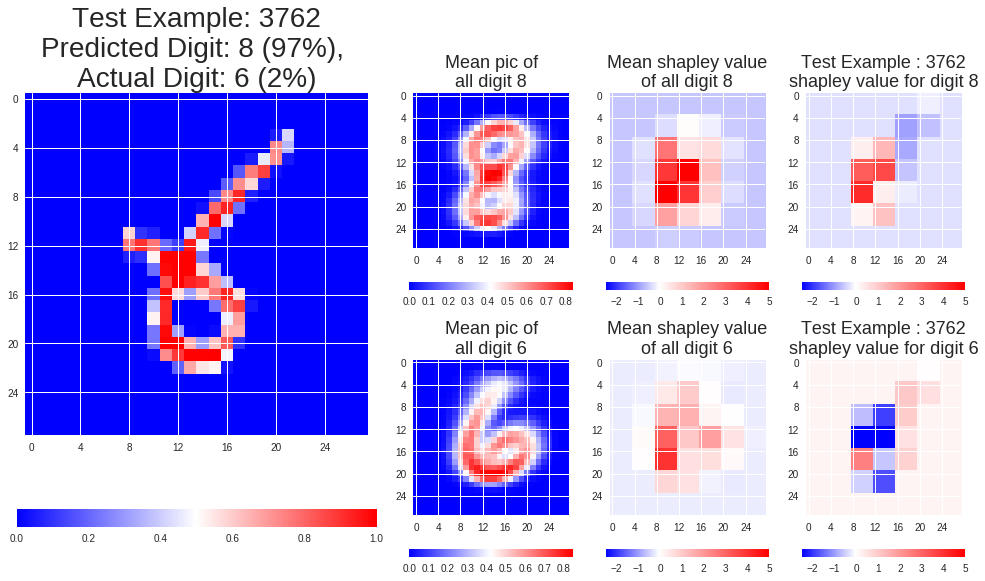

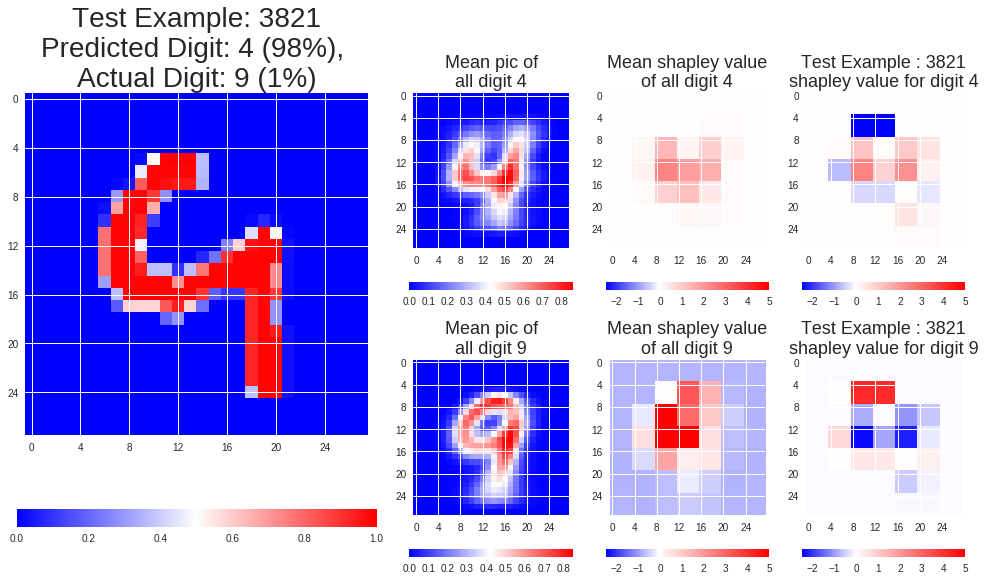

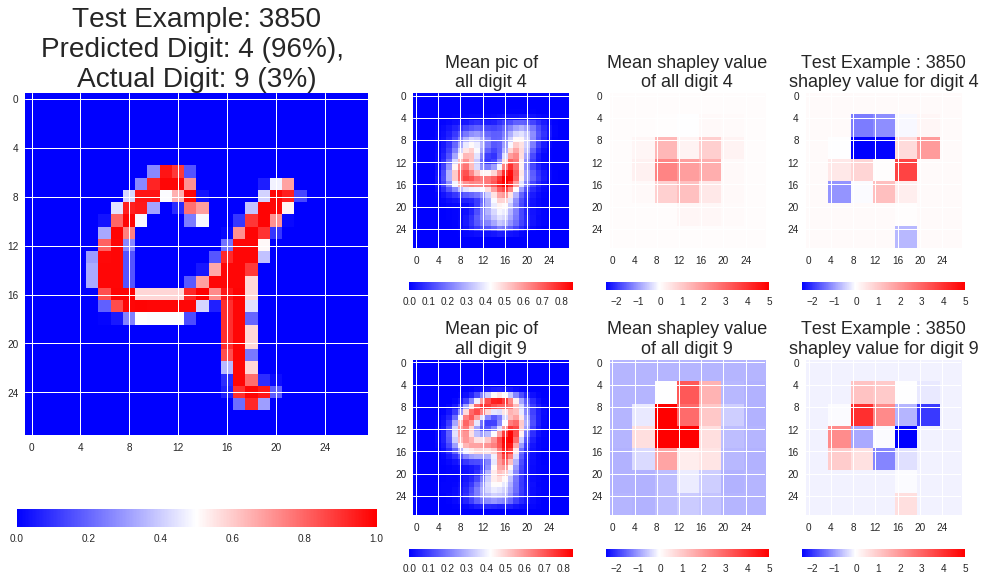

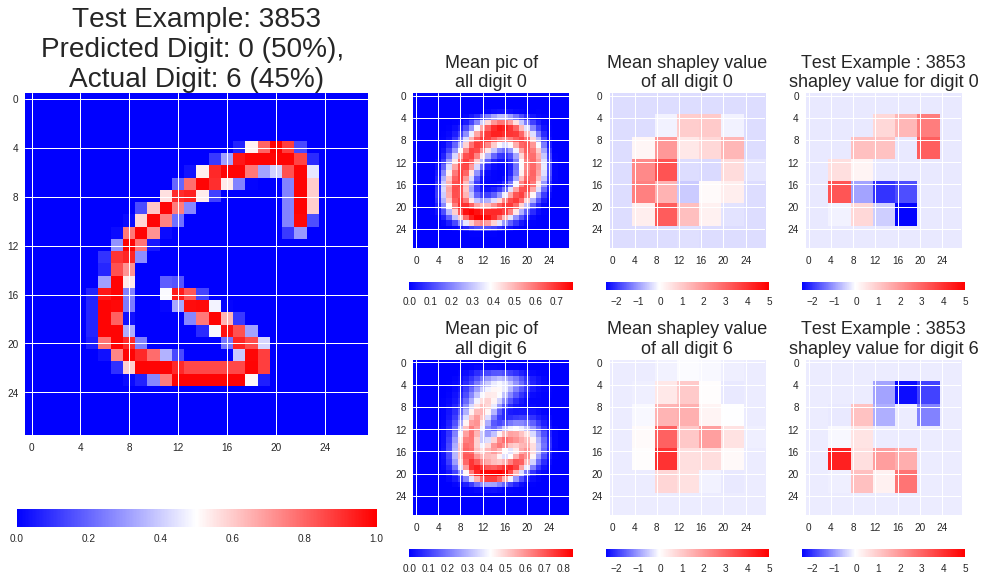

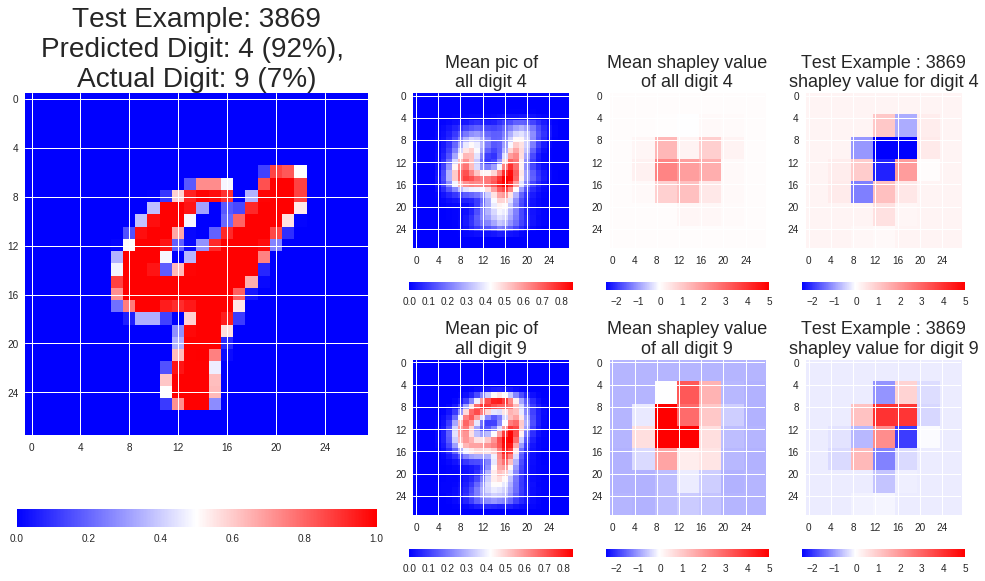

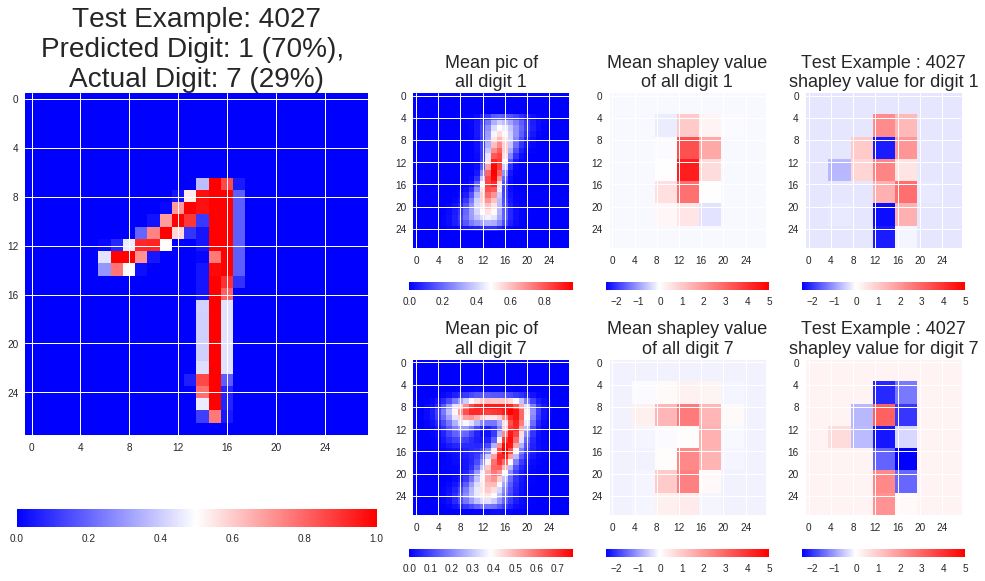

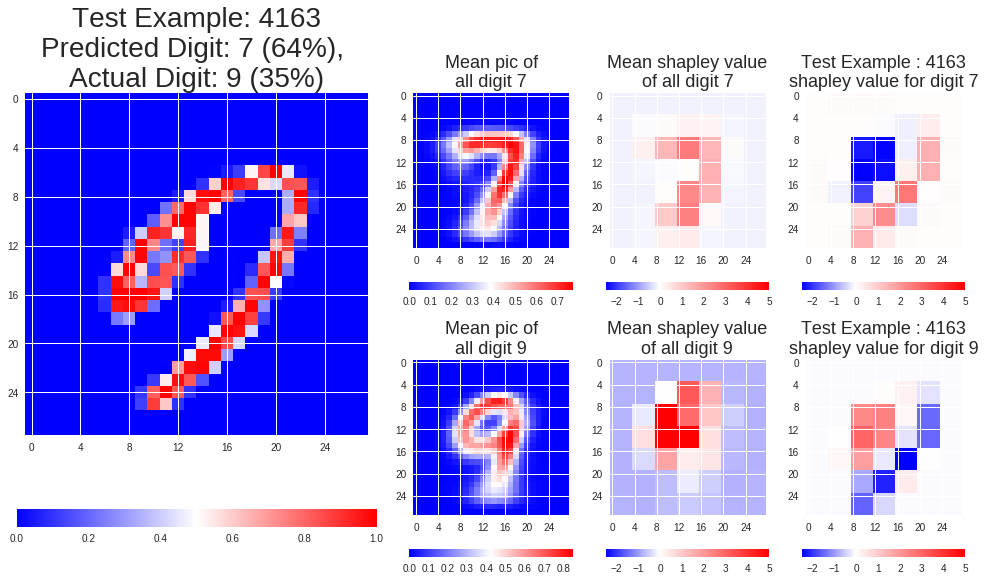

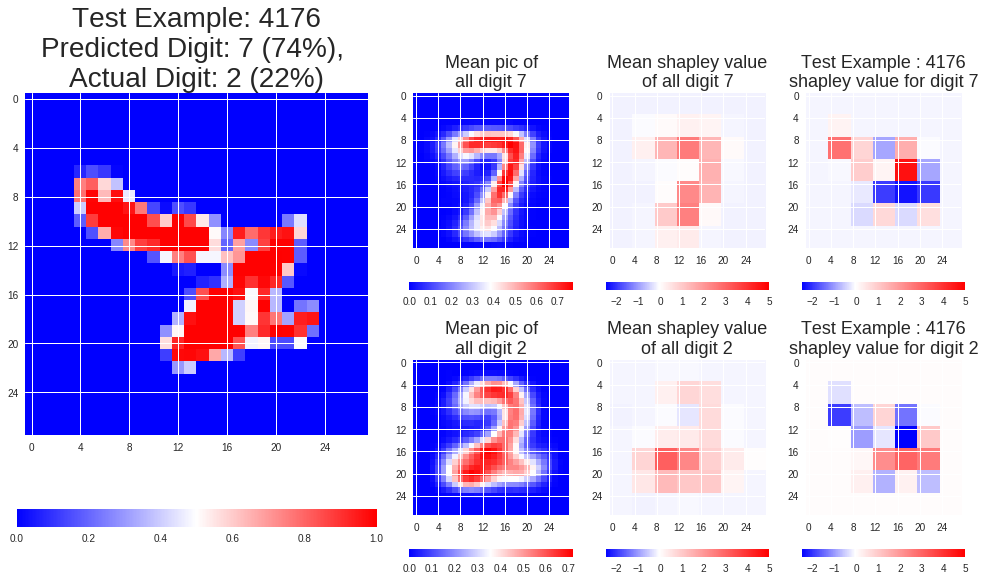

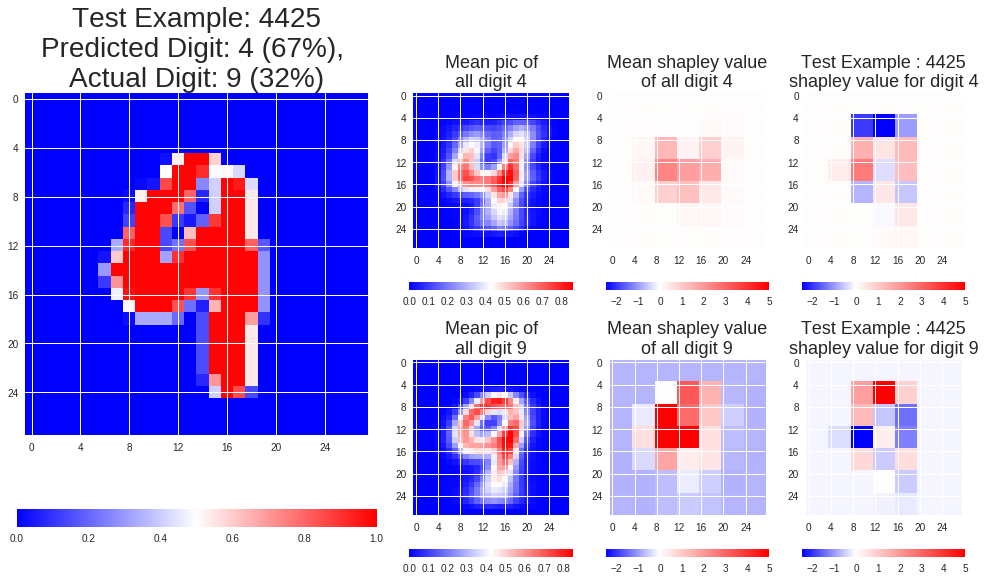

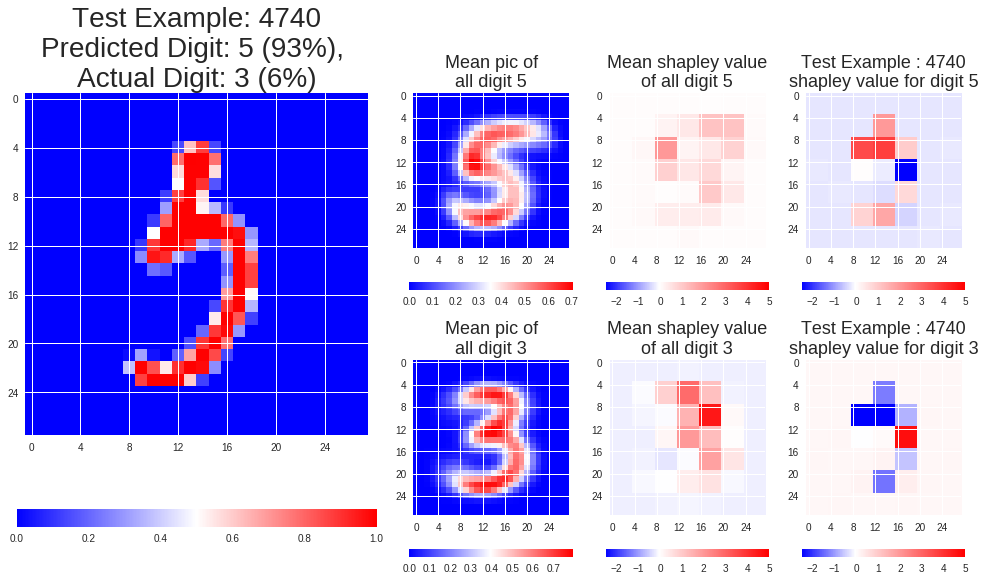

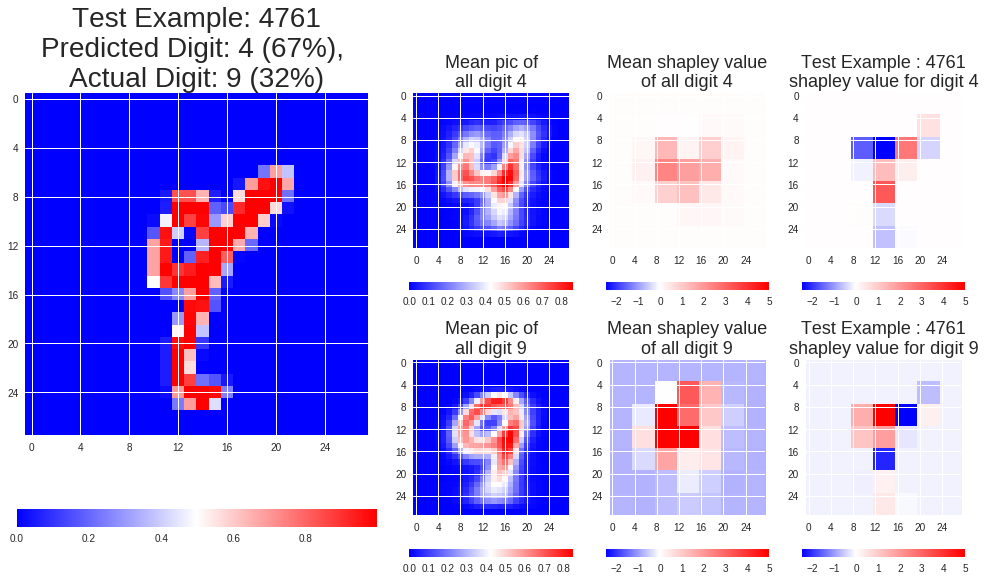

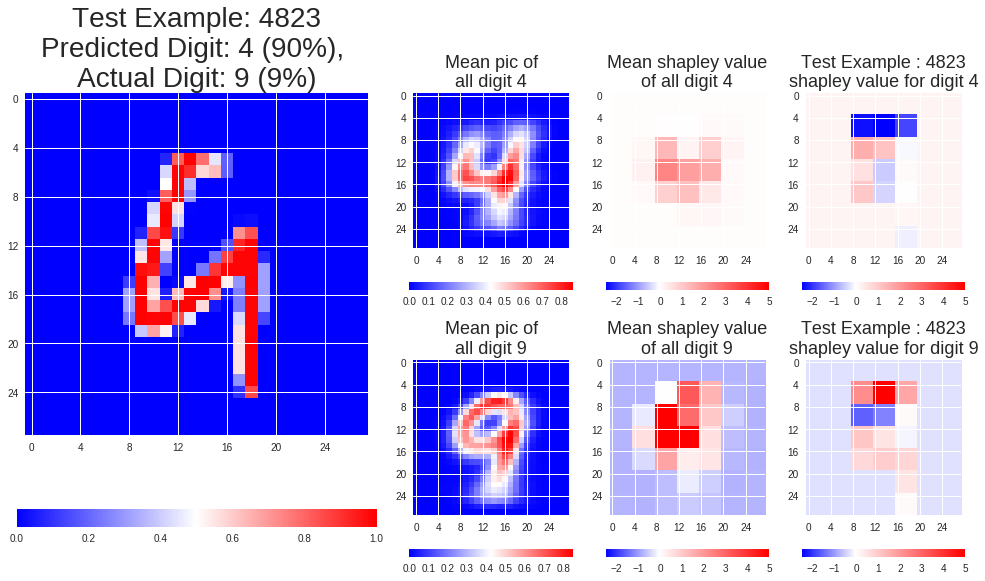

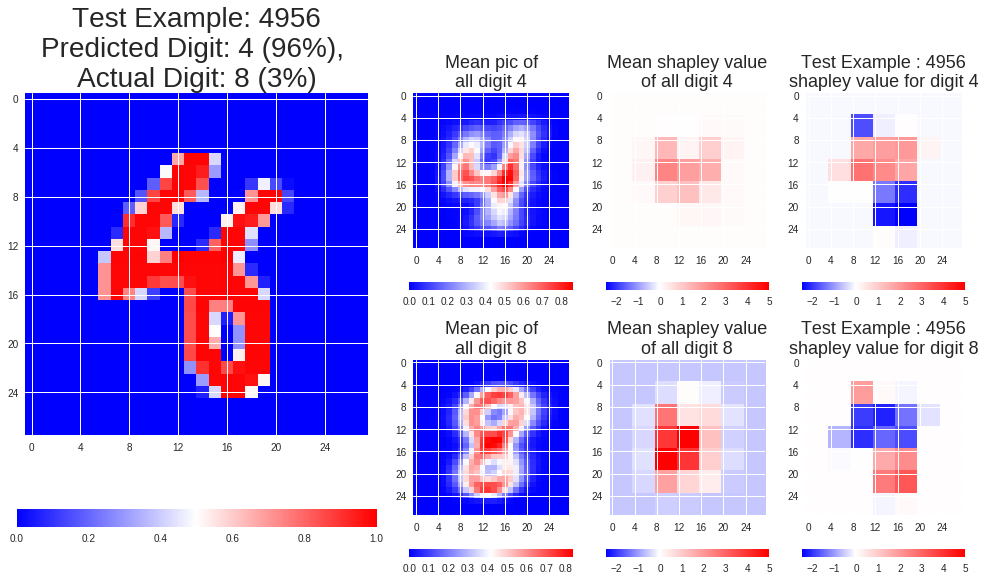

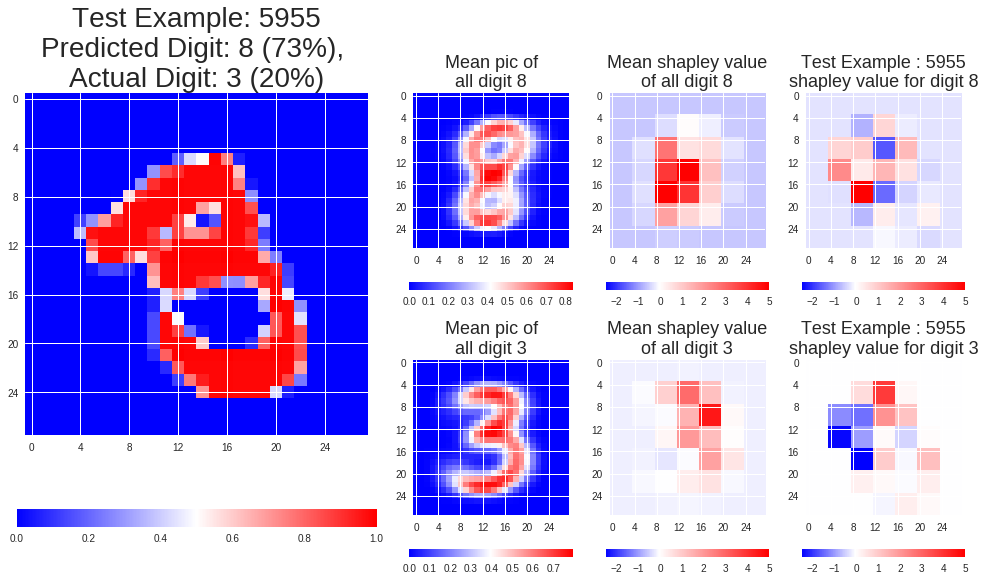

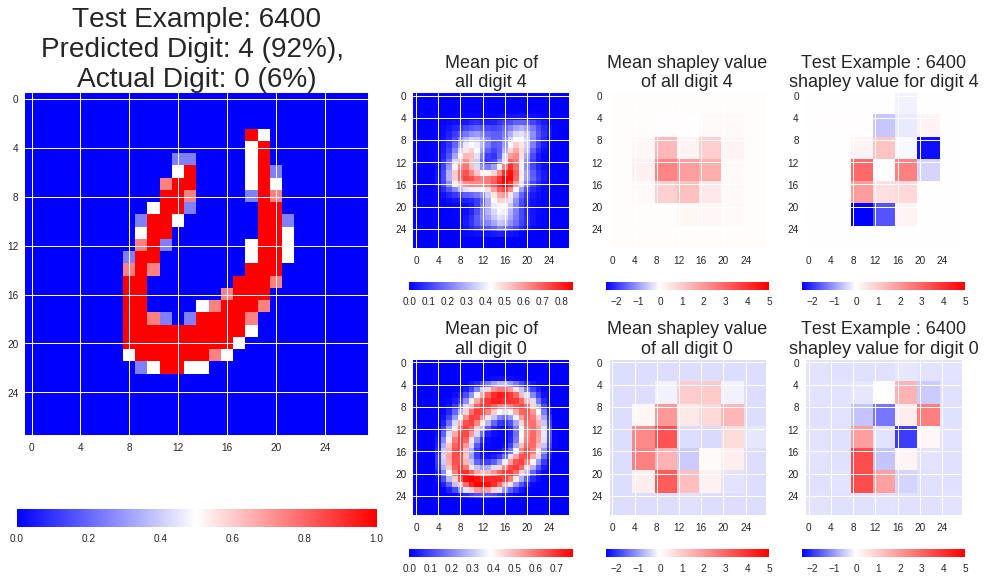

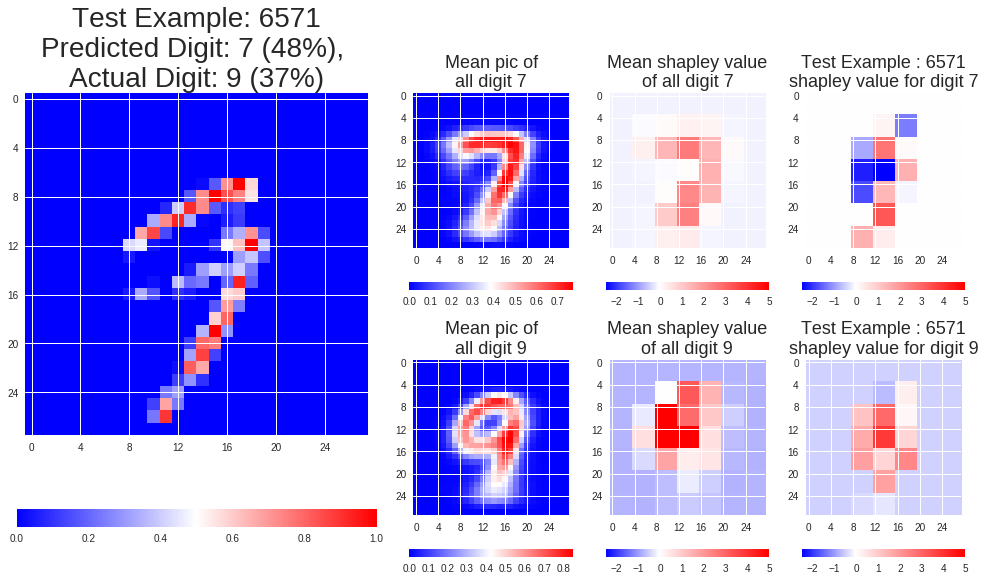

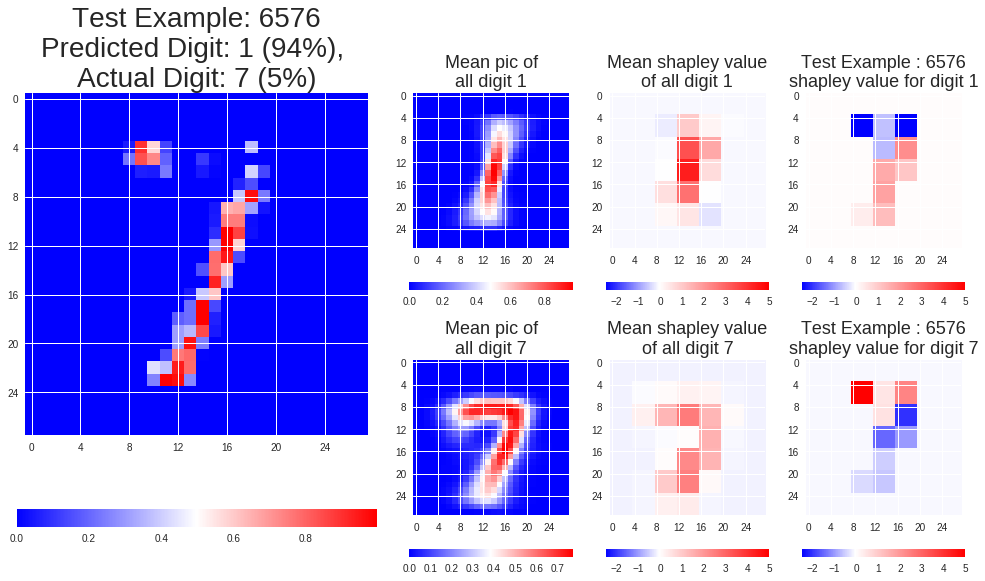

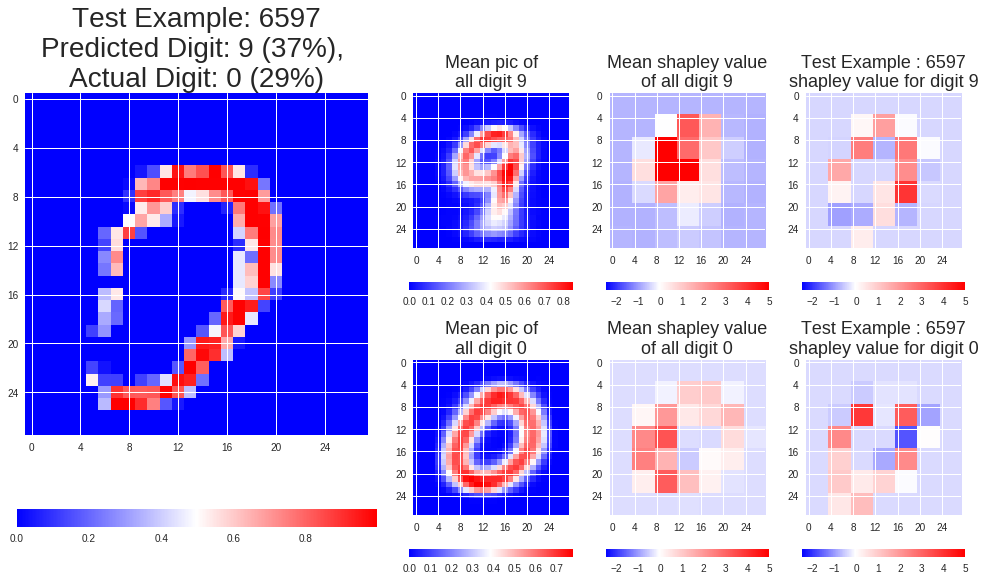

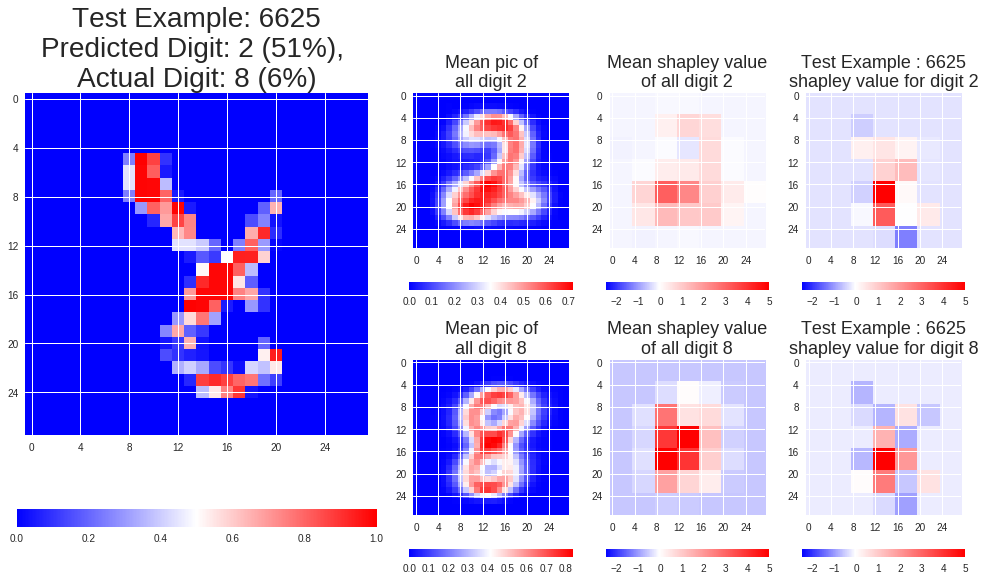

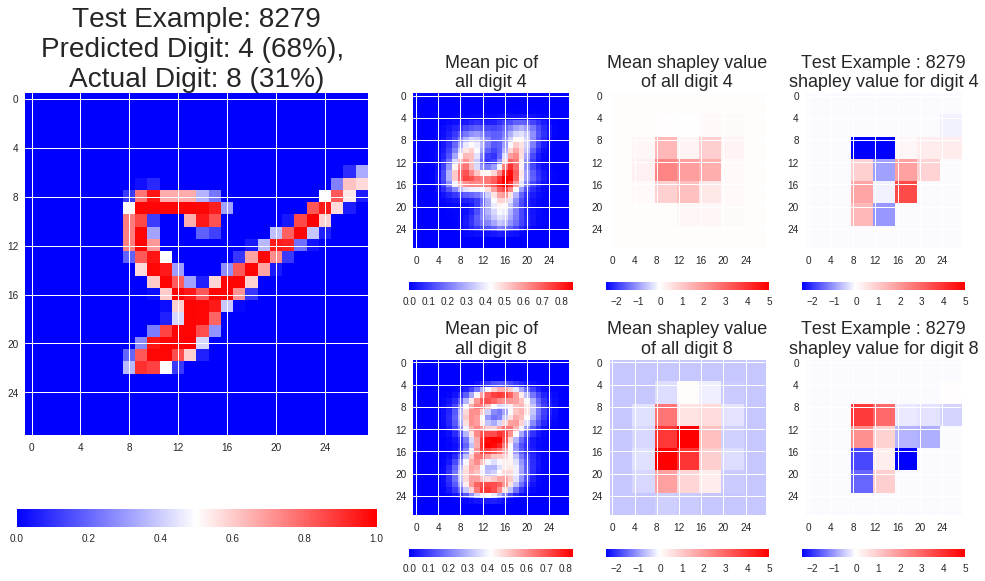

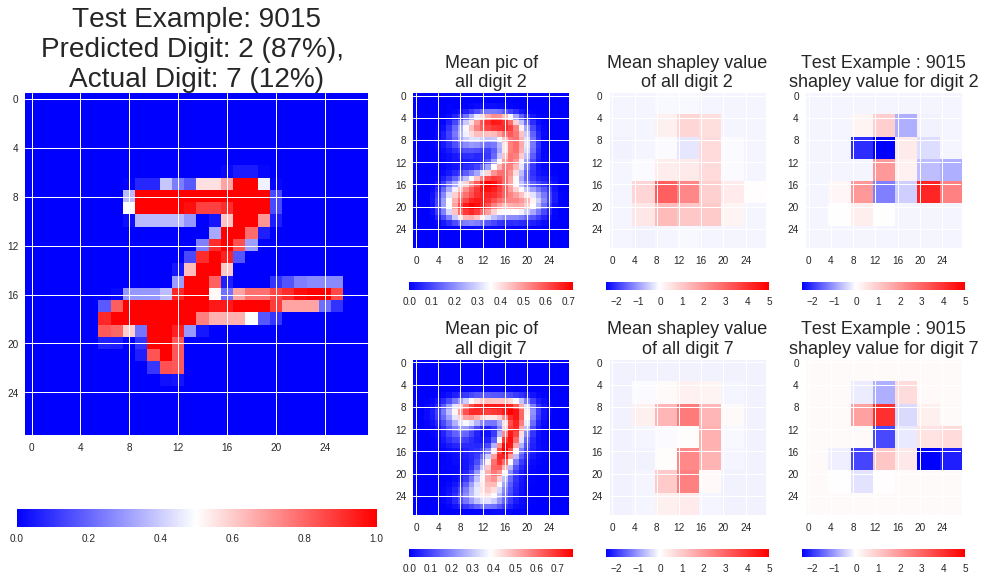

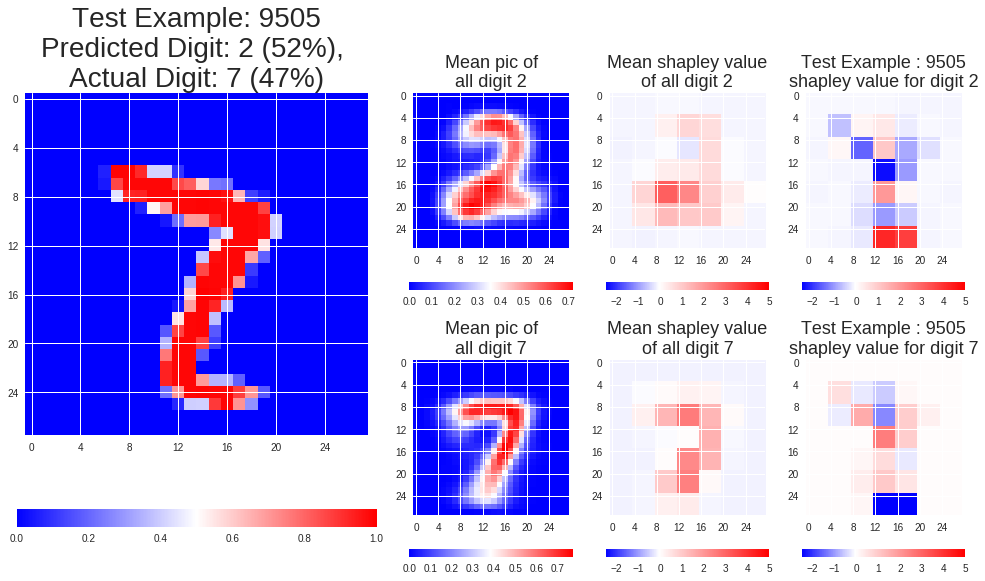

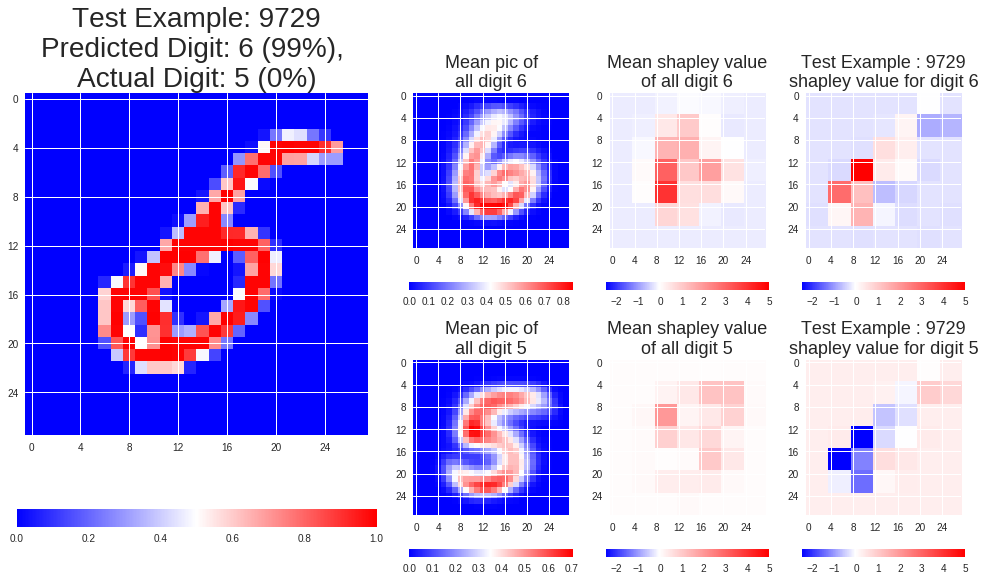

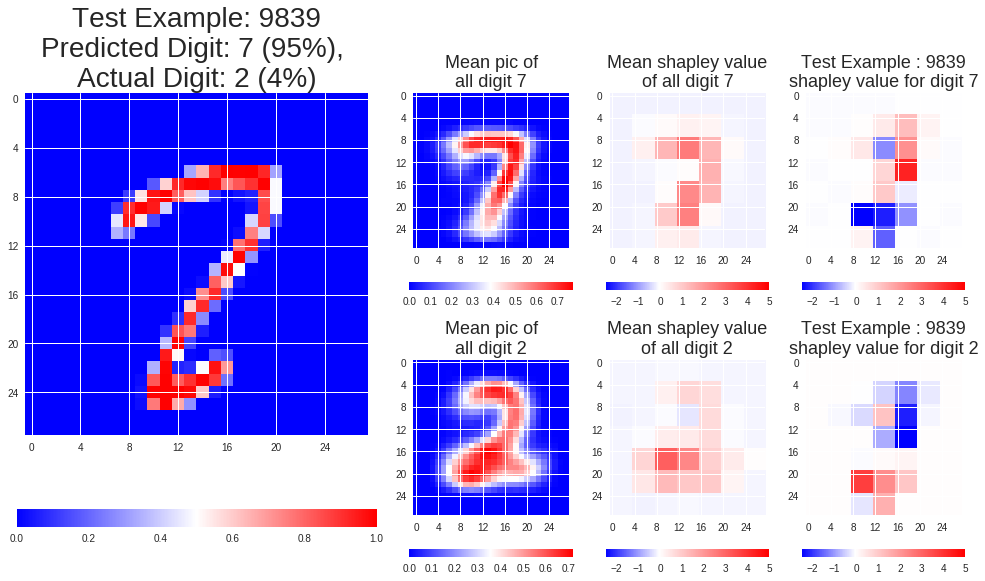

In [14]:
#@title
from matplotlib.gridspec import GridSpec
id_wrong_predict = np.argwhere((np.argmax(pred,-1) == np.argmax(y_val,-1))==0)
y_label_max = np.argmax(y_val,-1)
y_pred_max = np.argmax(pred,-1)
for i in id_wrong_predict:
    overlaid_img = np.zeros((28,28,3))
    #f,ax = plt.subplots(3,3,figsize=(9,10))
    fig=plt.figure(figsize=(17,9))

    gs=GridSpec(2,5) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,4]) # First row, first column
    ax2=fig.add_subplot(gs[0,2]) # First row, second column
    ax3=fig.add_subplot(gs[0,3]) # First row, third column
    ax0=fig.add_subplot(gs[:,:2]) # Second row, span all columns
    ax4=fig.add_subplot(gs[1,4]) # First row, first column
    ax5=fig.add_subplot(gs[1,2]) # First row, second column
    ax6=fig.add_subplot(gs[1,3])
    ax = [ax0,ax1,ax2,ax3,ax4,ax5,ax6]
    ax_id = 0
    preds_i = (100*model.predict(np.array([dictt[i[0]][0]]))).astype(np.int32)
    top2 =  np.argsort(preds_i)[0][-2:][::-1]
    cax = ax[0].imshow(dictt[i[0]][0][:,:,0],cmap = plt.cm.bwr)
    overlaid_img[:,:,0] = dictt[i[0]][0][:,:,0]
    ax[ax_id].set_title('Test Example: %s\nPredicted Digit: %s (%s%%), \nActual Digit: %s (%s%%)'
                        %(i[0],y_pred_max[i[0]],preds_i[0][y_pred_max[i[0]]],
                          y_label_max[i[0]],preds_i[0][y_label_max[i[0]]]),
                       fontsize=28)
    cb = plt.colorbar(cax,  ax=ax[ax_id],
                 orientation="horizontal")
    ax_id += 1
    phi = dictt[i[0]][1]
    phi = (phi - np.stack([np.mean(phi,-1),],-1))/np.stack([np.std(phi,-1),],-1)
    for ii in range(7):
            ax[ii].set_xticks(np.arange(0,28,4))
            ax[ii].set_yticks(np.arange(0,28,4))
    for digit in list(top2[:1:1])+[y_label_max[i[0]],]:# highest preduiction  plus actual label
        min_val =np.min(phi[digit])
        max_val = np.max(phi[digit])
        shapley_image = np.copy(dictt[0][2].astype(np.float32))
        counter =0 
        for x in range(28):
            for y in range(28):
                shapley_image[x,y] = phi[digit][int(shapley_image[x,y])]
                counter += 1
        cax = ax[ax_id].imshow(shapley_image,
                                vmin=-2.5, vmax=5,
                                cmap = bwr)
        cb = plt.colorbar(cax,  ax=ax[ax_id],
                         orientation="horizontal")
        ax[ax_id].set_title('Test Example : %s\nshapley value for digit %s'%(i[0],digit),fontsize=18)
        ax_id += 1
        cax = ax[ax_id ].imshow(dictt_avg_plts[(digit,0)],cmap = plt.cm.bwr);
        cb = plt.colorbar(cax,  ax=ax[ax_id],
                         orientation="horizontal")
        ax[ax_id].set_title('Mean pic of\nall digit %s'%digit,fontsize=18)
        ax_id += 1
        cax = ax[ax_id].imshow(dictt_avg_plts[(digit,2+digit)],cmap = bwr,
                              vmin=-2.5,vmax=5);
        cb = plt.colorbar(cax,  ax=ax[ax_id],
                         orientation="horizontal")
        ax[ax_id].set_title('Mean shapley value\nof all digit %s'%digit,fontsize=18)
        ax_id += 1
        #cb = plt.colorbar(cax,  ax=ax[1,1+int(np.argwhere(top2 == digit)[0])],orientation="horizontal")
        overlaid_img[:,:,2] = dictt_avg_plts[(digit,0)]
    #ax[1,0].imshow(overlaid_img)
    plt.show();

# 7 gradient based methods (integrated gradients and concept activation)

In [15]:
link = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/75fed3df69952839e20426827b30869b7f6515ac'
from IPython.display import Image
from IPython.core.display import HTML
Image(url= './presentation/Integrated_grad_formula.png', width=800, height=500)

[0, 0, 0, 0, 58, 0, 0, 0, 0, 40]


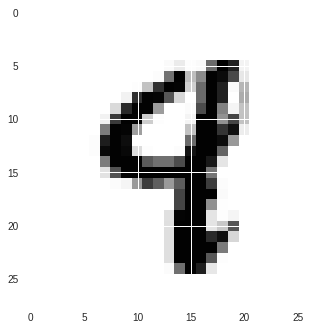

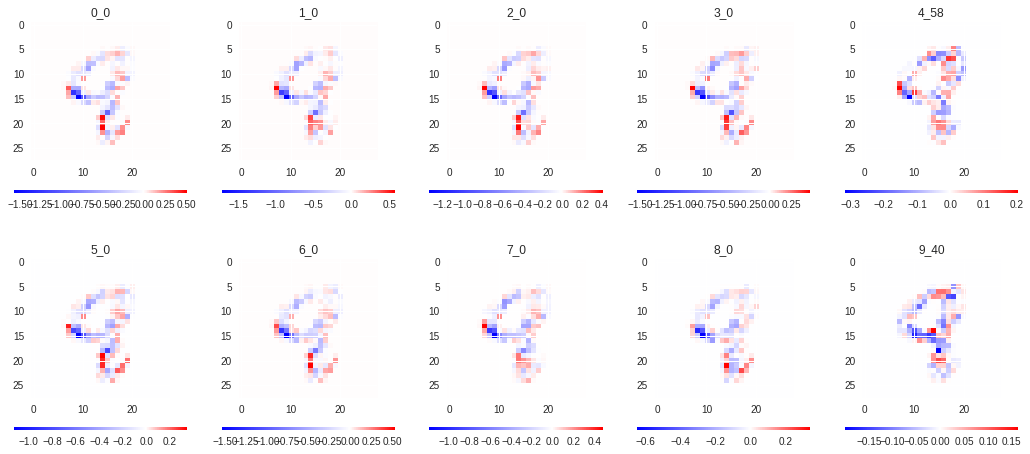

In [16]:
# integrated gradients
sess = K.get_session() 
model.load_weights('mnist.h5')
from matplotlib.colors import LinearSegmentedColormap
tr_id = 359
input_X = X_val[tr_id:tr_id+1]
input_X0 = input_X*0 + np.min(input_X)
grad = np.zeros(input_X.shape)
pred = model.predict(input_X)[0]
print map(lambda x : int(x*100),pred)
m = 50.
vary_pic = np.zeros((28*28,28,28,1))
counter = 0
for i in range(28):
    for j in range(28):
        vary_pic[counter,i,j]=1 
        counter += 1

for i in range(10):
    grad = np.zeros(input_X.shape)
    if i ==0:
        plt.imshow(input_X[0,:,:,0]);plt.show()
        plt.show()
        f,ax = plt.subplots(2,5,figsize=(18,8))
    if True:#i == np.argmax(pred):
        outputTensor =model.layers[-2].output[:,i] # (?,)
        listOfVariableTensors = model.inputs[0] # (?,28,28,1)
        gradients = K.gradients(outputTensor, listOfVariableTensors)
        for num in range(50):
            grad  += (input_X-input_X0)*sess.run(gradients, feed_dict= {model.input:  input_X0 + (num/m)*(input_X-input_X0)})[0] 
            if num%50==49:
                per = (np.max(grad[0,:,:,0]/m))/(np.max(grad[0,:,:,0]/m)-np.min(grad[0,:,:,0]/m))
                cdict1 = {'red':  ((0, 0, 0),   # <- at 0.0, the red component is 0
                                   (1-per, 1, 1.0),   # <- at 0.5, the red component is 1
                                   (1, 1.0, 1.0)),  # <- at 1.0, the red component is 0

                         'green': ((0, 0.0, 0.0),   # <- etc.
                                   (1-per, 1.0, 1.0),
                                   (1, 0.0, 0.0)),

                         'blue':  ((0, 1.0, 1.0),
                                   (1-per, 1.0, 1.0),
                                   (1, 0, 0))
                         }
                bwr=LinearSegmentedColormap('bwr', cdict1)
                cax = ax[i//5,(i-5)%5].imshow(grad[0,:,:,0]/m,cmap=bwr)
                cb = plt.colorbar(cax, cmap=plt.cm.bwr,ax=ax[i//5,(i-5)%5],
                          orientation="horizontal", aspect=70) 
                ax[i//5,(i-5)%5].set_title(str(i)+'_'+str(map(lambda x : int(x*100),pred)[i]))
plt.show()

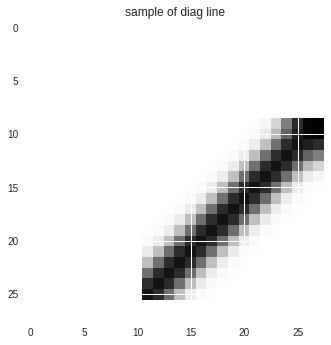

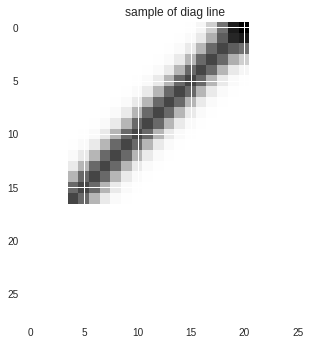

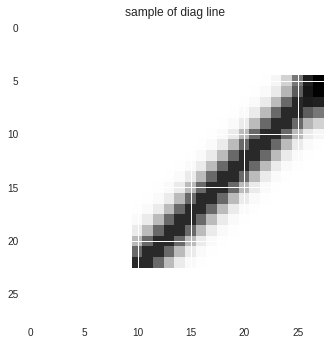

In [17]:
# concept actiation vectors, concept used is diagonal
# MAKING diagonal images
import cv2
digonal_sample = np.zeros((3000,28,28))
input_X0 = input_X[0,:,:,0]*0
for i in range(0,28,1):
    for j in range(0,28,1):
        if i in [j+1,j-1,j,j+2,j-2]: #thickness of two
            input_X0[i,j] = 1

def make_strip_samples(start,end,input_X0,digonal_sample):
    for sample in range(start,end):
        leng, = np.random.choice(range(10,20),1)
        offsetX, =  np.random.choice(range(28-leng),1)
        offsetY, =  np.random.choice(range(28-leng),1)
        sub_pic = np.copy(input_X0[:leng,:leng])
        digonal_sample[sample,offsetX:offsetX+leng,offsetY:offsetY+leng] = sub_pic
    return digonal_sample
    
digonal_sample = make_strip_samples(0,1000,cv2.GaussianBlur(input_X0,(5,5),0),digonal_sample)


input_X0 = input_X[0,:,:,0]*0
for i in range(0,28,1):
    for j in range(0,28,1):
        if i in [j+1,j,j-1]:
            input_X0[i,j] = 1
digonal_sample = make_strip_samples(1000,2000,cv2.GaussianBlur(input_X0,(5,5),0),digonal_sample)


input_X0 = input_X[0,:,:,0]*0
for i in range(0,28,1):
    for j in range(0,28,1):
        if i in [j+1,j-1,j,j+2]:
            input_X0[i,j] = 1

digonal_sample = make_strip_samples(2000,3000,cv2.GaussianBlur(input_X0,(5,5),0),digonal_sample)
digonal_sample = digonal_sample[:,:,::-1]
if True:
    plt.imshow(digonal_sample[0]);plt.title('sample of diag line');plt.show()
    plt.imshow(digonal_sample[1000]);plt.title('sample of diag line');plt.show()
    plt.imshow(digonal_sample[2301]);plt.title('sample of diag line');plt.show()
digonal_sample = np.expand_dims(digonal_sample,-1)

In [18]:
# USING model.layers[4] output, the directional derivative can be from ANY layer
model2 = keras.models.Model(model.input,map(lambda x : x.output,model.layers)[4])
model2.summary()
pred_diag = np.mean(model2.predict(digonal_sample,batch_size =512//2),(1,2)) #mean poolng of layer from 2D to 1D
random_noise = 1.*np.random.randint(0,100,size=X_train[::18].shape)/100
pred_nondiag = np.mean(model2.predict(random_noise,batch_size =512//2),(1,2)) #mean poolng of layer from 2D to 1D
pred_X = np.concatenate([digonal_sample,random_noise],0)
print pred_diag.shape,pred_nondiag.shape,pred_X.shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
Total params: 44,960
Trainable params: 44,960
Non-trainable params: 0
_________________________________________________________________
(3000,

In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
sess = K.get_session() 
model.load_weights('mnist.h5')
if True:
    # train SVM from outputs from model layer
    pred_diag_unwrap = pred_diag
    pred_nondiag_unwrap = pred_nondiag
    pred_comb = np.concatenate([pred_diag_unwrap,pred_nondiag_unwrap],0)
    labels = np.array([1,]*3000 + [0,]*3056) 
    svm_model = LinearSVC().fit(pred_comb,labels)
    preds = svm_model.predict(pred_comb)
    print 'svm confusion matrix:\n',confusion_matrix(labels,preds)
    support_vec = svm_model.coef_
    for output in range(10):
        outputTensor =model.layers[-2].output[:,output] # (?,)
        listOfVariableTensors = map(lambda x : x.output,model.layers)[4]# (?,28,28,1)
        gradients = K.gradients(outputTensor, listOfVariableTensors)
        grad  = sess.run(gradients, feed_dict= {model.input:  X_train[:600]})[0][:,:,:,:] # 600,14,14,64
        grad = np.mean(grad,(1,2)) #mean pooling of gradients from 2D to 1D, # 600，1,1,64
        grad = np.reshape(grad,(600,64)) #reshape gradient to 64 vector
        grad2 = np.matmul(grad,svm_model.coef_.T/np.sum(svm_model.coef_.T**2)**.5) # get directional derivative
        print 'Mean directional derivative of mnist at logit :',output
        print np.round(np.mean(grad2),2)
        val2 = np.matmul(grad,svm_model.coef_.T/np.sum(svm_model.coef_.T**2)**.5)


svm confusion matrix: [[3056    0]
 [   0 3000]]
Mean directional derivative of mnist at logit : 0
-0.23
Mean directional derivative of mnist at logit : 1
0.11
Mean directional derivative of mnist at logit : 2
-0.19
Mean directional derivative of mnist at logit : 3
-0.27
Mean directional derivative of mnist at logit : 4
-0.2
Mean directional derivative of mnist at logit : 5
-0.23
Mean directional derivative of mnist at logit : 6
-0.24
Mean directional derivative of mnist at logit : 7
-0.02
Mean directional derivative of mnist at logit : 8
-0.38
Mean directional derivative of mnist at logit : 9
-0.28
